In [1]:
# load packages

import numpy as np
from pandas import read_csv
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import visualkit_delta as vkd
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
# define scenario
scenario_name = 'Seattle'
analysis_years = ['2018', '2050']
input_dir = 'inputs_' + scenario_name
plot_dir = 'plots_Seattle_2050'

lehd_file = 'US_naics.csv'
map_file = scenario_name + '_freight.geojson'
port_analysis = True

us_ton_to_ton = 0.907185
miles_to_km = 1.60934

CFS_to_FAF_mapping = {'For-hire Truck':'Truck', 
                      'Private Truck': 'Truck', 
                      'Rail/IMX': 'Rail and IMX', 
                      'Air':'Air and Parcel', 
                      'Parcel':'Air and Parcel'}

FAF_mode_lookup = {1: 'Truck', 2: 'Rail and IMX', 3: 'Other', 4: 'Air and Parcel', 
               5: 'Air and Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

commodity_label = {'bulk': 'Bulk', 'fuel_fert': 'Fuel, fertilizer and chemicals',
                  'interm_food': 'Food and interim product', 'mfr_goods': 'Manufactured goods',
                  'other':'Other'}

# 1 - Employment validation

In [95]:
# load PSRC employment data 
psrc_parcel_base_path = os.path.join(input_dir, 'parcel_data_2018.csv')
psrc_parcels_base = pd.read_csv(psrc_parcel_base_path, sep = ',')

psrc_parcel_2050_path = os.path.join(input_dir, 'parcel_data_2050.csv')
psrc_parcels_2050 = pd.read_csv(psrc_parcel_2050_path, sep = ',')
CT_in_PSRC = psrc_parcels_base.loc[:, 'FIPS'].unique()
CT_in_PSRC = [int(x) for x in CT_in_PSRC]

print(CT_in_PSRC)
psrc_parcels_2050.head(5)

[53033, 53035, 53053, 53061]


aparks  empedu_p  empfoo_p  empgov_p  empind_p  empmed_p  empofc_p  \
0       0         0         2         0         0         0         0   
1       0         0         0         0         4         3        18   
2       0        26         4         0        57        10        59   
3       0         9        10         0         5         1        11   
4       0         0         0         0        43         4         3   

   empoth_p  empret_p  emprsc_p  ...  District       district_name  \
0         0         2         0  ...       7.0  Renton-FedWay-Kent   
1         8         5         0  ...       7.0  Renton-FedWay-Kent   
2        18        19         0  ...       7.0  Renton-FedWay-Kent   
3         5         6         0  ...       7.0  Renton-FedWay-Kent   
4         2         3         0  ...       7.0  Renton-FedWay-Kent   

   CountyName   TAZ  BaseYear       GEOID10  place_name  State  County   FIPS  
0        King  1018      2018  5.303303e+14        Kent     53      33  53033  
1        King  1018      2018  5.303303e+14        Kent     53      33  53033  
2        King  1018      2018  5.303303e+14        Kent     53      33  53033  
3        King  1018      2018  5.303303e+14        Kent     53      33  53033  
4        King  1018      2018  5.303303e+14        Kent     53      33  53033  

[5 rows x 45 columns]

In [96]:
# load modeled results
output_dir_base = 'outputs_' + scenario_name
output_dir_2050 = 'outputs_' + scenario_name + '_2050'
synthetic_firms_base = \
read_csv(os.path.join(output_dir_base, 'synthetic_firms_with_location.csv'))
synthetic_firms_base = \
    synthetic_firms_base.loc[synthetic_firms_base['CBPZONE'].isin(CT_in_PSRC)]
print(synthetic_firms_base.Emp.sum())
synthetic_firms_2050 = \
read_csv(os.path.join(output_dir_2050, 'synthetic_firms_with_location.csv'))
synthetic_firms_2050 = \
    synthetic_firms_2050.loc[synthetic_firms_2050['CBPZONE'].isin(CT_in_PSRC)]
print(synthetic_firms_2050.Emp.sum())
synthetic_firms_2050.head(5)

2099791.420401242
3169069.7433536453


CBPZONE  FAFZONE  esizecat Industry_NAICS6_Make  Commodity_SCTG        Emp  \
0    53033      531         1               722A00               0   4.754970   
1    53033      531         1               311810               6   9.777384   
2    53033      531         1               4A0000               0  11.790666   
3    53033      531         1               4A0000               0  11.808428   
4    53033      531         1               4A0000               0  17.004491   

     BusID      MESOZONE        lat         lon  ParcelID   TAZ  
0  6329906  530330292061  47.441342 -122.242297         3  1018  
1  6331991  530330292061  47.440640 -122.242229         6  1018  
2  6330274  530330292061  47.440891 -122.242157         6  1018  
3  6330330  530330292061  47.440186 -122.242085         6  1018  
4  6331990  530330292061  47.440359 -122.241904         6  1018

In [97]:
# format PSRC parcel data
def format_parcel_data(psrc_parcels, value_name = 'PSRC_emp_2018'):
    """
    Format parcel data into a long table.

    Parameters:
    psrc_parcels (pd.DataFrame): DataFrame containing parcel data.

    Returns:
    pd.DataFrame: Formatted parcel data in long table format.
    """

    # Define sector names
    psrc_sector = ['PSRC_Education', 'PSRC_Government', 'PSRC_Industrial', 'PSRC_Medical',
                   'PSRC_Other', 'PSRC_Retail', 'PSRC_Office', 'PSRC_Service']

    # Map employment data to sector columns
    employment_columns = {
        'PSRC_Education': 'empedu_p',
        'PSRC_Government': 'empgov_p',
        'PSRC_Industrial': 'empind_p',
        'PSRC_Medical': 'empmed_p',
        'PSRC_Other': 'empoth_p',
        'PSRC_Retail': 'empret_p',
        'PSRC_Office': 'empofc_p',
        'PSRC_Service': ['empfoo_p', 'empsvc_p']
    }

    for sector, columns in employment_columns.items():
        if isinstance(columns, list):
            psrc_parcels.loc[:, sector] = psrc_parcels.loc[:, columns].sum(axis=1)
        else:
            psrc_parcels.loc[:, sector] = psrc_parcels.loc[:, columns]

    # Convert to long format
    psrc_emp_long = pd.melt(psrc_parcels, id_vars=['Census2010BlockGroup'],
                            value_vars=psrc_sector, 
                            var_name='industry', value_name=value_name)

    # Clean industry names
    psrc_emp_long.loc[:, 'industry'] = psrc_emp_long.loc[:, 'industry'].str.split('_').str[1]

    # Filter out rows with zero employment
    psrc_emp_long = psrc_emp_long.loc[psrc_emp_long[value_name] > 0]
    psrc_emp_long.loc[:, 'Census2010BlockGroup'] = \
    psrc_emp_long.loc[:, 'Census2010BlockGroup'].astype(int).astype(str).str.zfill(12)
    psrc_emp_long.rename(columns = {'Census2010BlockGroup': 'MESOZONE'}, inplace = True)
    psrc_emp_long = \
    psrc_emp_long.groupby(['MESOZONE', 'industry'])[value_name].sum().reset_index()
    return psrc_emp_long

In [98]:
psrc_parcels_base_long = format_parcel_data(psrc_parcels_base, 'PSRC_emp_2018')
print(len(psrc_parcels_base_long))
print(psrc_parcels_base_long.PSRC_emp_2018.sum())

psrc_parcels_2050_long = format_parcel_data(psrc_parcels_2050, 'PSRC_emp_2050')
print(len(psrc_parcels_2050_long))
print(psrc_parcels_2050_long.PSRC_emp_2050.sum())
psrc_parcels_2050_long.head(5)

14676
2009687
15865
3157305


MESOZONE    industry  PSRC_emp_2050
0  530330001002   Education             17
1  530330001002  Industrial             82
2  530330001002     Medical             62
3  530330001002      Office            265
4  530330001002       Other             17

In [99]:
# format SynthFirm data
industry_mapping = {
        'Other': ['11', '21', '23'],
        'Industrial': ['31', '32', '33', '22', '42', '48', '49'],
        'Retail': ['44', '45', '4A'],
        'Office': ['51', '52', '53', '54', '55', '56'],
        'Education': ['61'],
        'Medical': ['62'],
        'Service': ['71', '72', '81'],
        'Government': ['92', 'S0']
    }
def format_synthfirm_emp(firm_df, industry_mapping, 
                         value_name = 'SynthFirm_emp_2018'):
    """
    Assign PSRC industry code to synthetic firms and format output
    """

    # Assign PSRC industry code to synthetic firms
    firm_df.loc[:, 'n2'] = \
        firm_df.loc[:, 'Industry_NAICS6_Make'].astype(str).str[0:2]


    # Initialize industry column with NaN
    firm_df.loc[:, 'industry'] = np.nan

    # Assign industry codes
    for col, values in industry_mapping.items():
        firm_df.loc[firm_df['n2'].isin(values), 'industry'] = col

    # Convert to long format
    modeled_emp_long = firm_df.groupby(['MESOZONE', 'industry'])['Emp'].sum().reset_index()
    modeled_emp_long.rename(columns = {'Emp': value_name}, inplace = True)
    modeled_emp_long.loc[:, 'MESOZONE'] = \
    modeled_emp_long.loc[:, 'MESOZONE'].astype(int).astype(str).str.zfill(12)
    return modeled_emp_long


In [100]:
synthfirm_emp_base_long = \
format_synthfirm_emp(synthetic_firms_base, industry_mapping, 'SynthFirm_emp_2018')
print(synthfirm_emp_base_long.SynthFirm_emp_2018.sum())

synthfirm_emp_2050_long = \
format_synthfirm_emp(synthetic_firms_2050, industry_mapping, 'SynthFirm_emp_2050')
print(synthfirm_emp_2050_long.SynthFirm_emp_2050.sum())
synthfirm_emp_2050_long.head(5)

2099791.4204012416
3169069.7433536444


MESOZONE    industry  SynthFirm_emp_2050
0  530330001002  Industrial           73.894033
1  530330001002     Medical           21.824289
2  530330001002      Office          529.722432
3  530330001002       Other           21.604361
4  530330001002      Retail          153.296842

In [101]:
# calculate summary statistics

psrc_emp_comparison = pd.merge(psrc_parcels_2050_long, psrc_parcels_base_long, 
                         on = ['MESOZONE', 'industry'], how = 'left')
synthfirm_emp_comparison = pd.merge(synthfirm_emp_2050_long, synthfirm_emp_base_long,
                         on = ['MESOZONE', 'industry'], how = 'left')

print(len(psrc_emp_comparison))
psrc_emp_comparison.head(5)

15865


MESOZONE    industry  PSRC_emp_2050  PSRC_emp_2018
0  530330001002   Education             17            7.0
1  530330001002  Industrial             82          105.0
2  530330001002     Medical             62           22.0
3  530330001002      Office            265          155.0
4  530330001002       Other             17           18.0

In [102]:
import statsmodels.api as sm
plt.style.use('seaborn-v0_8-white')
sns.set(font_scale=1.4)
sns.set_style("white")
def plot_forecast_employment(data_to_compare, 
                             base_attr, future_attr, 
                             base_label, future_label, 
                             plot_filepath,
                            alpha = 0.3):
    # add regression statistics
    X = data_to_compare[base_attr]
    y = data_to_compare[future_attr]
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    lr_cons = est2.params['const']
    lr_dist = est2.params[base_attr]
    lr_r2 = est2.rsquared
    lr_cons_short = np.round(lr_cons, 2)
    lr_dist_short = np.round(lr_dist, 2)
    lr_r2_short = np.round(lr_r2, 2)

    # Determine max value for plot
    max_value = max(data_to_compare[base_attr].max(), 
                    data_to_compare[future_attr].max())

    # Create plot
    ax = sns.lmplot(
        data=data_to_compare,
        x=base_attr, y=future_attr, 
        height=4.5, aspect=1.2, line_kws={'color': 'grey'}, 
        scatter_kws={'alpha': alpha})

    # Add reference line
    plt.plot([0, max_value], [0, max_value], 'r--', label='y=x')

    # Set plot limits and labels
    plt.xlim([0, max_value])
    plt.ylim([0, max_value])

    title = f"{future_label}={lr_cons_short}+{lr_dist_short}x{base_label},\
    \n r2={lr_r2_short}"
    # Add title
    plt.title(title, fontsize=14)
    plt.xlabel(base_label)
    plt.ylabel(future_label)
    # Save plot
    plt.savefig(plot_filepath, dpi=200, bbox_inches='tight')
    plt.show()
    # Close plot to free up resources
    plt.close()

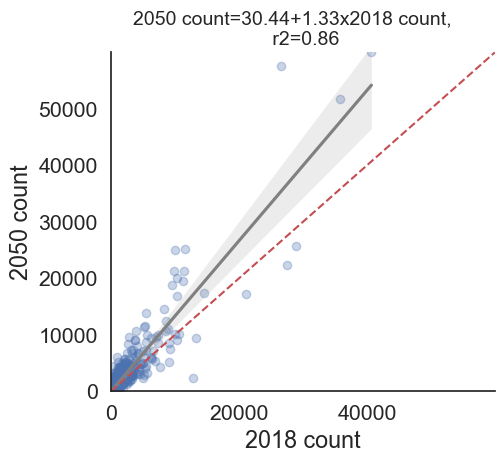

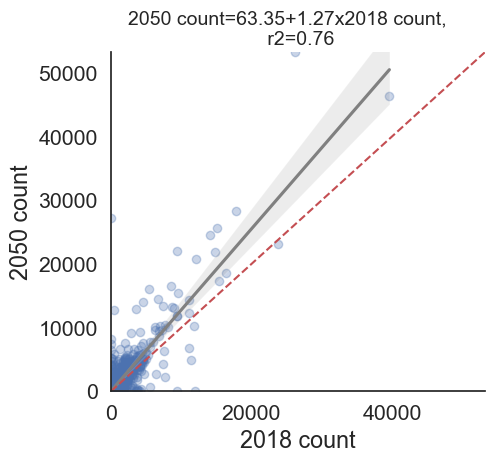

In [103]:
# pair plot by zone
psrc_emp_comparison.fillna(0, inplace = True)
psrc_emp_comparison_cbg = \
psrc_emp_comparison.groupby('MESOZONE')[['PSRC_emp_2018', 'PSRC_emp_2050']].sum().reset_index()
plot_filepath = os.path.join(plot_dir, 'PSRC_emp_comparison_cbg.png')
plot_forecast_employment(psrc_emp_comparison, 'PSRC_emp_2018', 
                                'PSRC_emp_2050', '2018 count', '2050 count', plot_filepath, alpha = 0.3)

synthfirm_emp_comparison.fillna(0, inplace = True)
synthfirm_emp_comparison_cbg = \
synthfirm_emp_comparison.groupby('MESOZONE')[['SynthFirm_emp_2018', 'SynthFirm_emp_2050']].sum().reset_index()
plot_filepath = os.path.join(plot_dir, 'synthfirm_emp_comparison_cbg.png')
plot_forecast_employment(synthfirm_emp_comparison, 'SynthFirm_emp_2018', 
                                'SynthFirm_emp_2050', '2018 count', '2050 count', plot_filepath, alpha = 0.3)

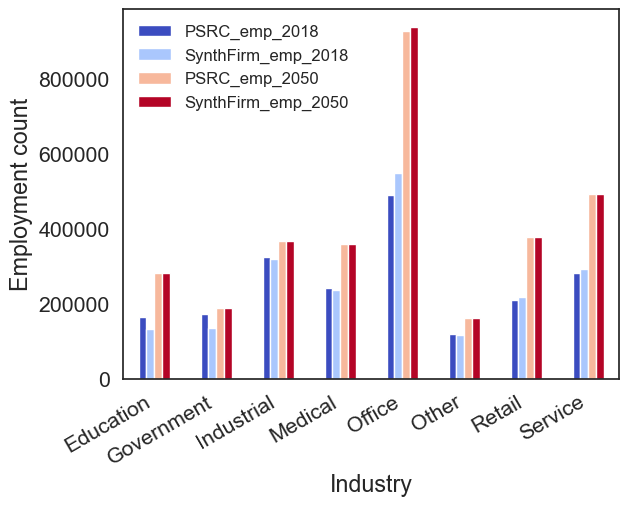

In [44]:
# bar plot by industry

psrc_emp_comparison_ind = \
psrc_emp_comparison.groupby('industry')[['PSRC_emp_2018', 'PSRC_emp_2050']].sum().reset_index()

synthfirm_emp_comparison_ind = \
synthfirm_emp_comparison.groupby('industry')[['SynthFirm_emp_2018', 'SynthFirm_emp_2050']].sum().reset_index()
emp_comparison_ind = pd.merge(psrc_emp_comparison_ind,
                              synthfirm_emp_comparison_ind,
                              on = 'industry',  how = 'left')
emp_comparison_ind.set_index('industry', inplace = True)
emp_comparison_ind = emp_comparison_ind[['PSRC_emp_2018', 'SynthFirm_emp_2018', 
                                        'PSRC_emp_2050', 'SynthFirm_emp_2050']]
emp_comparison_ind.plot(kind = 'bar', colormap = 'coolwarm')
plt.xticks(rotation = 30, ha = 'right')
plt.xlabel('Industry')
plt.ylabel('Employment count')
plt.legend(loc = 2, fontsize = 12)
plt.savefig(os.path.join(plot_dir, 'emp_forecast_by_industry.png'),
            dpi = 300, bbox_inches = 'tight')

plt.show()
emp_comparison_ind.to_csv(os.path.join(plot_dir, 'emp_forecast_by_industry.csv'))

# 2 - Commodity Flow Validation

In [3]:
# load FAF data
# mapping FAF mode to SynthFirm mode

region_code = [411, 531, 532, 539]
focus_region = 531
faf_data = read_csv('Validation/' + 'FAF5.6.1.csv', sep = ',')
#load parameters
sctg_group_lookup = read_csv('SynthFirm_parameters/' + 'SCTG_Groups_revised.csv', sep = ',')
cfs_faf_lookup = read_csv('SynthFirm_parameters/' + 'CFS_FAF_LOOKUP.csv', sep = ',')

sctg_names = sctg_group_lookup['SCTG_Name'].unique()
sctg_group_definition = sctg_group_lookup.loc[:, ['SCTG_Group', 'SCTG_Name']]
sctg_group_definition = sctg_group_definition.drop_duplicates()

faf_data.loc[:, 'Mode'] = faf_data.loc[:, 'dms_mode'].map(FAF_mode_lookup)

faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')

trade_type_id = 1 # domestic only
if port_analysis:
    faf_data_domestic = faf_data.copy()
else:
    faf_data_domestic = faf_data.loc[faf_data['trade_type'] == trade_type_id] #select domestic shipment only

# faf_data_domestic = faf_data.loc[faf_data['trade_type'] == trade_type_id]

faf_data_domestic = \
faf_data_domestic.loc[faf_data_domestic['Mode'] != 'Other']
print(faf_data_domestic.loc[:, 'Mode'].unique())

if focus_region is not None: # regional
    faf_outflow = faf_data_domestic.loc[faf_data_domestic['dms_orig'] == focus_region]
    faf_inflow = faf_data_domestic.loc[faf_data_domestic['dms_dest'] == focus_region]

else: # national
    faf_outflow = faf_data_domestic.copy()
    faf_inflow = faf_data_domestic.copy()


['Truck' 'Air and Parcel' 'Rail and IMX']


In [10]:
# load SynthFirm outputs
def process_flow_output(flow_data, CFS_to_FAF_mapping, focus_region,
                       add_sctg_label = False):
 
    # Map mode choices to FAF modes
    flow_data.loc[:, 'Mode'] = flow_data.loc[:, 'mode_choice'].map(CFS_to_FAF_mapping)
    print(flow_data.loc[:, 'Mode'].unique())
    # Drop rows with missing mode information
    flow_data = flow_data.dropna(subset=['Mode'])
    if add_sctg_label:
        flow_data = pd.merge(flow_data, sctg_group_definition,
                             on = 'SCTG_Group', how = 'left')

    # Split data into outflow and inflow DataFrames
    outflow = flow_data.loc[flow_data['orig_FAFID'] == focus_region]
    inflow = flow_data.loc[flow_data['dest_FAFID'] == focus_region]

    return outflow, inflow
    
mesozone_id_lookup = read_csv(os.path.join(input_dir, 'zonal_id_lookup_final.csv'))

output_dir_base = 'outputs_' + scenario_name
output_dir_2050 = 'outputs_' + scenario_name + '_2050'

synthfirm_output_base = \
read_csv(os.path.join(output_dir_base, 'domestic_b2b_flow_summary_mesozone.csv'))

if port_analysis:
    international_output_base = \
    read_csv(os.path.join(output_dir_base, 'international_b2b_flow_summary_mesozone.csv'))
    port_outflow_base, port_inflow_base = \
    process_flow_output(international_output_base, CFS_to_FAF_mapping,
                        focus_region, add_sctg_label = True)
    
synthfirm_outflow_base, synthfirm_inflow_base = \
process_flow_output(synthfirm_output_base, CFS_to_FAF_mapping, focus_region)


synthfirm_output_2050 = read_csv(os.path.join(output_dir_2050, 'domestic_b2b_flow_summary_mesozone.csv'))
if port_analysis:
    international_output_2050 = \
    read_csv(os.path.join(output_dir_2050, 'international_b2b_flow_summary_mesozone.csv'))
    port_outflow_2050, port_inflow_2050 = \
    process_flow_output(international_output_2050, CFS_to_FAF_mapping, 
                        focus_region, add_sctg_label = True)
synthfirm_outflow_2050, synthfirm_inflow_2050 = \
process_flow_output(synthfirm_output_2050, CFS_to_FAF_mapping, focus_region)


synthfirm_outflow_base.head(5)

['Rail and IMX' 'Truck' 'Air and Parcel']
['Air and Parcel' 'Truck' 'Rail and IMX' nan]
['Rail and IMX' 'Truck' 'Air and Parcel']
['Air and Parcel' 'Truck' 'Rail and IMX' nan]


SellerZone  orig_FAFID orig_FAFNAME  BuyerZone  dest_FAFID  \
284098  5.302997e+11       531.0      Seattle    20004.0        20.0   
284099  5.302997e+11       531.0      Seattle    20004.0        20.0   
284100  5.302997e+11       531.0      Seattle    20004.0        20.0   
284101  5.302997e+11       531.0      Seattle    20031.0       151.0   
284102  5.302997e+11       531.0      Seattle    20067.0       300.0   

       dest_FAFNAME  Commodity_SCTG  SCTG_Group  SCTG_Name mode_choice  \
284098       Alaska            33.0         4.0  mfr_goods         Air   
284099       Alaska            35.0         4.0  mfr_goods         Air   
284100       Alaska            35.0         4.0  mfr_goods      Parcel   
284101     Honolulu            33.0         4.0  mfr_goods         Air   
284102      Montana            38.0         4.0  mfr_goods         Air   

              tmiles  ShipmentLoad  count  outbound  inbound  Distance  \
284098  2.172749e+06      1.357509   1375         1        0       NaN   
284099  2.442964e+05      0.152634   2827         1        0       NaN   
284100  2.333840e+06      1.458156  27008         1        0       NaN   
284101  2.318668e+04      0.008214      8         1        0       NaN   
284102  6.048864e+02      0.001028     79         1        0       NaN   

          Source            Mode  
284098  Domestic  Air and Parcel  
284099  Domestic  Air and Parcel  
284100  Domestic  Air and Parcel  
284101  Domestic  Air and Parcel  
284102  Domestic  Air and Parcel

In [5]:
print(synthfirm_outflow_base['ShipmentLoad'].sum())
print(synthfirm_inflow_base['ShipmentLoad'].sum())
print(synthfirm_outflow_2050['ShipmentLoad'].sum())
print(synthfirm_inflow_2050['ShipmentLoad'].sum())

129155.60016169405
156740.66574100006
210092.49371048337
226501.11802599998


In [6]:
# generate attributes needed by all sectors
param_dir = 'SynthFirm_parameters'
us_counties = gpd.read_file(os.path.join(param_dir, 'US_countries.geojson'))
# geoid +  land area
us_counties.loc[:, 'area'] = (us_counties.loc[:, 'ALAND'] + us_counties.loc[:, 'AWATER'])/ 1000000 # in km^2
us_counties.loc[:, 'GEOID'] = us_counties.loc[:, 'GEOID'].astype(np.int64).astype(str).str.zfill(5)

us_county_df = pd.DataFrame(us_counties.drop(columns = 'geometry'))

us_county_short_df = us_county_df[['GEOID', 'area']]

# spatial crosswalk
mesozone_to_county = mesozone_id_lookup[['MESOZONE', 'CBPZONE', 'FAFID',  'FAFNAME']]
mesozone_to_county.loc[:, 'MESOZONE'] = mesozone_to_county.loc[:, 'MESOZONE'].astype(np.int64)

In [6]:
# define scenario naming system

scenario_prefix = {output_dir_base: 'base_2017',
                  output_dir_2050: 'forecast_2050'}

year_mapping = {'2017': '2017',
                '2050': '2050'}


In [7]:
# pre-process region map
region_map = gpd.read_file(os.path.join(input_dir, map_file))
region_map.dropna(subset = ['geometry'], inplace = True)
# calculate land area
region_map.loc[:, "area"] = \
region_map['geometry'].to_crs({'proj':'cea'}).map(lambda p: p.area / 10**6) 

agg_level = 'MESOZONE'
# plot firm and employment results by CBG zone

region_map.loc[:, 'MESOZONE'] = \
region_map.loc[:, 'MESOZONE'].astype(np.int64).astype(str).str.zfill(12)
region_map['FAFID'] = region_map['FAFID'].astype(int)

if focus_region is not None: # regional
    region_map = region_map.loc[region_map['FAFID'] == focus_region]
region_map_df = pd.DataFrame(region_map.drop(columns=['geometry']))
print(len(region_map_df))
region_map_df.head(5)

3046


GEOID  FAFID      MESOZONE  CBPZONE      area
1639  530330293053    531  530330293053    53033  0.891907
1640  530330205002    531  530330205002    53033  0.435127
1642  530530620003    531  530530620003    53053  0.291051
1644  530530613002    531  530530613002    53053  0.254453
1645  530610527055    531  530610527055    53061  0.595708

# 3 - Data processing and aggregation

## 3.1  SynthFirm data processing

In [8]:
# Data aggregation function

def gen_comm_by_zone(synthfirm_output, region_map_df, 
                       zonal_id, col_attr, 
                       output_var, output_prefix):

    group_var = [zonal_id, col_attr]
    tonnage_in_region = synthfirm_output.groupby(group_var)[[output_var]].sum()
    tonnage_in_region = tonnage_in_region.reset_index()
    tonnage_in_region = tonnage_in_region.rename(columns = {zonal_id: 'MESOZONE'})
    tonnage_in_region['MESOZONE'] = \
    tonnage_in_region['MESOZONE'].astype(np.int64).astype(str).str.zfill(12)


    col_groups = synthfirm_output[col_attr].unique().tolist()
    col_groups.append('total')
    #print(col_groups)
    
    tonnage_by_zone = pd.pivot_table(tonnage_in_region, 
                                     index = ['MESOZONE'],
                                      columns = col_attr, values = output_var, aggfunc = 'sum')
    tonnage_by_zone.loc[:, 'total'] = tonnage_by_zone.sum(axis = 1)   
    tonnage_by_zone = tonnage_by_zone.reset_index()

    
    tonnage_by_zone = \
    pd.merge(region_map_df, tonnage_by_zone, on='MESOZONE', how='left')
    tonnage_by_zone.fillna(0, inplace = True)
    for attr in col_groups:
        # print(attr)
        attr_out = output_prefix + '_' + attr + '_per_area'
        tonnage_by_zone.loc[:,attr_out] = \
        tonnage_by_zone.loc[:, attr] * us_ton_to_ton/ \
        tonnage_by_zone.loc[:, 'area']
    tonnage_by_zone.drop(columns = col_groups, inplace = True)
    return(tonnage_by_zone)      
                           

In [11]:
# production by SCTG
if port_analysis:
    port_outflow_base.rename(columns = {'MESOZONE': 'SellerZone'},
                            inplace = True)
    synthfirm_outflow_base = pd.concat([synthfirm_outflow_base,
                                         port_outflow_base])

    port_outflow_2050.rename(columns = {'MESOZONE': 'BuyerZone'},
                            inplace = True)
    synthfirm_outflow_2050 = pd.concat([synthfirm_outflow_2050,
                                         port_outflow_2050])
print(synthfirm_outflow_base.groupby('Source')['ShipmentLoad'].sum())
print(synthfirm_outflow_2050.groupby('Source')['ShipmentLoad'].sum())
production_by_sctg_base = \
                            gen_comm_by_zone(synthfirm_outflow_base, 
                                             region_map_df, 
                                               'SellerZone', 'SCTG_Name', 
                                               'ShipmentLoad', '2017_prod')

production_by_sctg_2050 = \
                            gen_comm_by_zone(synthfirm_outflow_2050, region_map_df, 
                                               'SellerZone', 'SCTG_Name', 
                                               'ShipmentLoad', '2050_prod')  

production_by_sctg_base.head(5)

Source
Domestic    129155.600162
Export       45145.378925
Import       16090.478470
Name: ShipmentLoad, dtype: float64
Source
Domestic    210092.493710
Export       78287.419459
Import       25481.903227
Name: ShipmentLoad, dtype: float64


GEOID  FAFID      MESOZONE  CBPZONE      area  \
0  530330293053    531  530330293053    53033  0.891907   
1  530330205002    531  530330205002    53033  0.435127   
2  530530620003    531  530530620003    53053  0.291051   
3  530530613002    531  530530613002    53053  0.254453   
4  530610527055    531  530610527055    53061  0.595708   

   2017_prod_mfr_goods_per_area  2017_prod_interm_food_per_area  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   2017_prod_fuel_fert_per_area  2017_prod_bulk_per_area  \
0                           0.0                      0.0   
1                           0.0                      0.0   
2                           0.0                      0.0   
3                           0.0                      0.0   
4                           0.0                      0.0   

   2017_prod_other_per_area  2017_prod_total_per_area  
0                       0.0                       0.0  
1                       0.0                       0.0  
2                       0.0                       0.0  
3                       0.0                       0.0  
4                       0.0                       0.0

In [12]:
# production by mode
production_by_mode_base = \
                            gen_comm_by_zone(synthfirm_outflow_base, region_map_df, 
                                               'SellerZone', 'Mode', 
                                               'ShipmentLoad', '2017_prod')

production_by_mode_2050 = \
                            gen_comm_by_zone(synthfirm_outflow_2050, region_map_df, 
                                                'SellerZone', 'Mode', 
                                               'ShipmentLoad', '2050_prod')  
production_by_mode_2050.head(5)

GEOID  FAFID      MESOZONE  CBPZONE      area  \
0  530330293053    531  530330293053    53033  0.891907   
1  530330205002    531  530330205002    53033  0.435127   
2  530530620003    531  530530620003    53053  0.291051   
3  530530613002    531  530530613002    53053  0.254453   
4  530610527055    531  530610527055    53061  0.595708   

   2050_prod_Air and Parcel_per_area  2050_prod_Truck_per_area  \
0                                0.0                       0.0   
1                                0.0                       0.0   
2                                0.0                       0.0   
3                                0.0                       0.0   
4                                0.0                       0.0   

   2050_prod_Rail and IMX_per_area  2050_prod_total_per_area  
0                              0.0                       0.0  
1                              0.0                       0.0  
2                              0.0                       0.0  
3                              0.0                       0.0  
4                              0.0                       0.0

In [13]:
# consumption by SCTG
if port_analysis:
    port_inflow_base.rename(columns = {'MESOZONE': 'BuyerZone'},
                            inplace = True)
    synthfirm_inflow_base = pd.concat([synthfirm_inflow_base,
                                         port_inflow_base])

    port_inflow_2050.rename(columns = {'MESOZONE': 'BuyerZone'},
                            inplace = True)
    synthfirm_inflow_2050 = pd.concat([synthfirm_inflow_2050,
                                         port_inflow_2050])
    
consumption_by_sctg_base = \
                            gen_comm_by_zone(synthfirm_inflow_base, region_map_df, 
                                                'BuyerZone', 'SCTG_Name',
                                               'ShipmentLoad', '2017_cons')
consumption_by_sctg_2050 = \
                            gen_comm_by_zone(synthfirm_inflow_2050, region_map_df, 
                                                'BuyerZone', 'SCTG_Name', 
                                               'ShipmentLoad', '2050_cons')  


In [14]:
# consumption by mode

consumption_by_mode_base = \
                            gen_comm_by_zone(synthfirm_inflow_base, region_map_df, 
                                               'BuyerZone', 'Mode', 
                                               'ShipmentLoad',  '2017_cons')
consumption_by_mode_2050 = \
                            gen_comm_by_zone(synthfirm_inflow_2050, region_map_df, 
                                               'BuyerZone', 'Mode', 
                                               'ShipmentLoad', '2050_cons')  


In [15]:
def gen_comm_summary(synthfirm_output, group_var, output_attr, output_name, year_id, scenario, add_total = True):

    summary_by_sector = synthfirm_output.groupby(group_var)[[output_attr]].sum()

    if output_name == 'Load':
        summary_by_sector.loc[:,output_attr] = \
        summary_by_sector.loc[:, output_attr] * us_ton_to_ton

    if output_name == 'Ton-km':
        summary_by_sector.loc[:,output_attr] = \
        summary_by_sector.loc[:, output_attr] * us_ton_to_ton * miles_to_km
    if add_total:
        summary_by_sector.loc['total'] = summary_by_sector.sum()
    summary_by_sector = summary_by_sector.reset_index()
    summary_by_sector.loc[:, 'Scenario'] = f'{scenario} ({year_id})'
    summary_by_sector.rename(columns = {output_attr: output_name}, inplace = True)

    
    return(summary_by_sector) 

# tonnage production by SCTG
model_base_prod_by_sctg = gen_comm_summary(synthfirm_outflow_base, 
                                      ['SCTG_Name'], 'ShipmentLoad', 
                                      'Load', '2017',  'Baseline')

model_2050_prod_by_sctg = gen_comm_summary(synthfirm_outflow_2050, 
                                      ['SCTG_Name'], 'ShipmentLoad', 
                                      'Load', '2050', 'Forecast')


modeled_prod_by_sctg = pd.concat([model_base_prod_by_sctg, 
                                     model_2050_prod_by_sctg])
modeled_prod_by_sctg.loc[:, 'Source'] = 'SynthFirm'

# tonnage production by mode
model_base_prod_by_mode = gen_comm_summary(synthfirm_outflow_base, 
                                      ['Mode'], 'ShipmentLoad', 'Load', '2017',  'Baseline',
                                     add_total = False)

model_2050_prod_by_mode = gen_comm_summary(synthfirm_outflow_2050, 
                                      ['Mode'], 'ShipmentLoad', 'Load', '2050', 'Forecast',
                                     add_total = False)


modeled_prod_by_mode = pd.concat([model_base_prod_by_mode, 
                                     model_2050_prod_by_mode])
modeled_prod_by_mode.loc[:, 'Source'] = 'SynthFirm'

# tonnage production by source
model_base_prod_by_source = gen_comm_summary(synthfirm_outflow_base, 
                                      ['Source'], 'ShipmentLoad', 'Load', '2017',  'Baseline',
                                     add_total = False)

model_2050_prod_by_source = gen_comm_summary(synthfirm_outflow_2050, 
                                      ['Source'], 'ShipmentLoad', 'Load', '2050', 'Forecast',
                                     add_total = False)


modeled_prod_by_source = pd.concat([model_base_prod_by_source, 
                                     model_2050_prod_by_source])
modeled_prod_by_source.rename(columns = {'Source': 'Type'}, inplace = True)
modeled_prod_by_source.loc[:, 'Source'] = 'SynthFirm'
modeled_prod_by_source

Type           Load         Scenario     Source
0  Domestic  117168.023133  Baseline (2017)  SynthFirm
1    Export   40955.210580  Baseline (2017)  SynthFirm
2    Import   14597.040711  Baseline (2017)  SynthFirm
0  Domestic  190592.758907  Forecast (2050)  SynthFirm
1    Export   71021.172622  Forecast (2050)  SynthFirm
2    Import   23116.800379  Forecast (2050)  SynthFirm

In [17]:
# tonnage consumption by SCTG
model_base_cons_by_sctg = gen_comm_summary(synthfirm_inflow_base, 
                                      ['SCTG_Name'], 'ShipmentLoad', 
                                      'Load', '2017',  'Baseline')

model_2050_cons_by_sctg = gen_comm_summary(synthfirm_inflow_2050, 
                                      ['SCTG_Name'], 'ShipmentLoad', 
                                      'Load', '2050', 'Forecast')


modeled_cons_by_sctg = pd.concat([model_base_cons_by_sctg, 
                                     model_2050_cons_by_sctg])
modeled_cons_by_sctg.loc[:, 'Source'] = 'SynthFirm'

# tonnage consumption by mode
model_base_cons_by_mode = gen_comm_summary(synthfirm_inflow_base, 
                                      ['Mode'], 'ShipmentLoad', 'Load', '2017',  'Baseline',
                                     add_total = False)

model_2050_cons_by_mode = gen_comm_summary(synthfirm_inflow_2050, 
                                      ['Mode'], 'ShipmentLoad', 'Load', '2050', 'Forecast',
                                     add_total = False)


modeled_cons_by_mode = pd.concat([model_base_cons_by_mode, 
                                     model_2050_cons_by_mode])
modeled_cons_by_mode.loc[:, 'Source'] = 'SynthFirm'

# tonnage consumption by source
model_base_cons_by_source = gen_comm_summary(synthfirm_inflow_base, 
                                      ['Source'], 'ShipmentLoad', 'Load', '2017',  'Baseline',
                                     add_total = False)

model_2050_cons_by_source = gen_comm_summary(synthfirm_inflow_2050, 
                                      ['Source'], 'ShipmentLoad', 'Load', '2050', 'Forecast',
                                     add_total = False)


modeled_cons_by_source = pd.concat([model_base_cons_by_source, 
                                     model_2050_cons_by_source])
modeled_cons_by_source.rename(columns = {'Source': 'Type'}, inplace = True)
modeled_cons_by_source.loc[:, 'Source'] = 'SynthFirm'
modeled_cons_by_source

Type           Load         Scenario     Source
0  Domestic  142192.780850  Baseline (2017)  SynthFirm
1    Export   35067.140999  Baseline (2017)  SynthFirm
2    Import   17018.709403  Baseline (2017)  SynthFirm
0  Domestic  205478.416756  Forecast (2050)  SynthFirm
1    Export   66990.907231  Forecast (2050)  SynthFirm
2    Import   17627.670933  Forecast (2050)  SynthFirm

In [18]:
modeled_prod_by_sctg.to_csv(os.path.join(plot_dir, 'synthfirm_production_summary_tonnage_by_sctg.csv'))
modeled_prod_by_mode.to_csv(os.path.join(plot_dir, 'synthfirm_production_summary_tonnage_bymode.csv'))
modeled_prod_by_source.to_csv(os.path.join(plot_dir, 'synthfirm_production_summary_tonnage_bysource.csv'))

modeled_cons_by_sctg.to_csv(os.path.join(plot_dir, 'synthfirm_consumption_summary_tonnage_by_sctg.csv'))
modeled_cons_by_mode.to_csv(os.path.join(plot_dir, 'synthfirm_consumption_summary_tonnage_bymode.csv'))
modeled_cons_by_source.to_csv(os.path.join(plot_dir, 'synthfirm_consumption_summary_tonnage_bysource.csv'))

In [29]:
# tonnage by zone and SCTG
model_base_by_sctg_zone = gen_comm_summary(synthfirm_output_base, 
                                           ['orig_FAFID', 'SCTG_Name'], 
                                           'ShipmentLoad', 'Load', '2017',  'Baseline_Model',
                                     add_total = False)

model_2050_by_sctg_zone = gen_comm_summary(synthfirm_output_2050, 
                                           ['orig_FAFID', 'SCTG_Name'], 
                                           'ShipmentLoad', 'Load', '2050', 'Forecast_Model', 
                                           add_total = False)

modeled_results_by_sctg_zone = \
pd.concat([model_base_by_sctg_zone, model_2050_by_sctg_zone])
modeled_results_by_sctg_zone.rename(columns = {'orig_FAFID': 'FAF'}, inplace = True)

modeled_results_by_sctg_zone.head(5)

FAF    SCTG_Name       Load               Scenario
0  11.0    mfr_goods   2.061848  Baseline_Model (2017)
1  12.0  interm_food   6.694060  Baseline_Model (2017)
2  19.0  interm_food  10.314746  Baseline_Model (2017)
3  19.0    mfr_goods   7.670817  Baseline_Model (2017)
4  20.0  interm_food  87.509883  Baseline_Model (2017)

In [30]:
# # tonnage by zone and mode
model_base_by_mode_zone = \
gen_comm_summary(synthfirm_output_base, ['orig_FAFID', 'Mode'], 
                 'ShipmentLoad', 'Load', '2017',  'Baseline', 
                 add_total = False)

model_2050_by_mode_zone = \
gen_comm_summary(synthfirm_output_2050, ['orig_FAFID', 'Mode'], 
                 'ShipmentLoad', 'Load', '2050', 'Forecast', 
                 add_total = False)

modeled_results_by_mode_zone = \
pd.concat([model_base_by_mode_zone, model_2050_by_mode_zone])
modeled_results_by_mode_zone.rename(columns = {'orig_FAFID': 'FAF'}, inplace = True)

tmile_base_by_mode_zone = \
gen_comm_summary(synthfirm_output_base, ['orig_FAFID', 'Mode'], 
                 'tmiles', 'Ton-km', '2017',  'Baseline', add_total = False)

tmile_2050_by_mode_zone = \
gen_comm_summary(synthfirm_output_2050, ['orig_FAFID', 'Mode'], 
                 'tmiles', 'Ton-km', '2050', 'Forecast', add_total = False)

tmile_results_by_mode_zone = \
pd.concat([tmile_base_by_mode_zone, tmile_2050_by_mode_zone])
tmile_results_by_mode_zone.rename(columns = {'orig_FAFID': 'FAF'}, 
                                  inplace = True)

tmile_results_by_mode_zone.head(5)

FAF            Mode        Ton-km         Scenario
0  11.0  Air and Parcel  3.042632e+06  Baseline (2017)
1  11.0    Rail and IMX  1.448420e+05  Baseline (2017)
2  11.0           Truck  5.212849e+06  Baseline (2017)
3  12.0    Rail and IMX  3.647975e+07  Baseline (2017)
4  12.0           Truck  8.072372e+05  Baseline (2017)

In [31]:
plt.style.use('seaborn-v0_8-white')
sns.set(font_scale=1.4)
sns.set_style("white")

3387.6255443414175


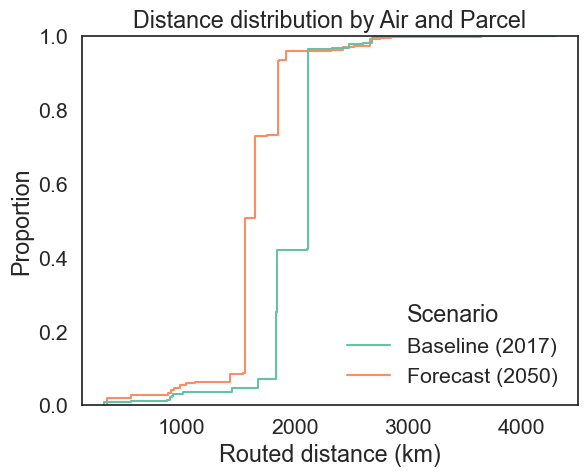

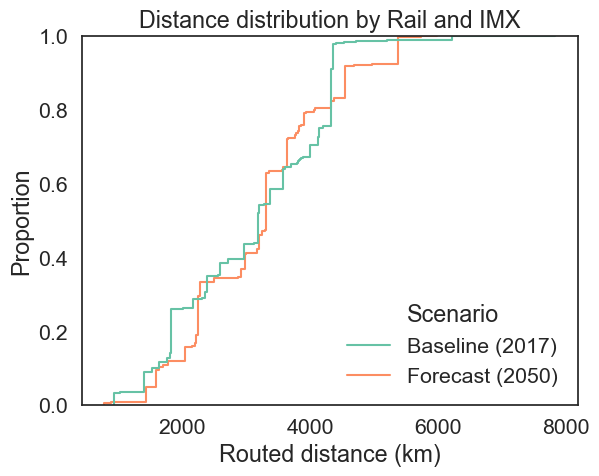

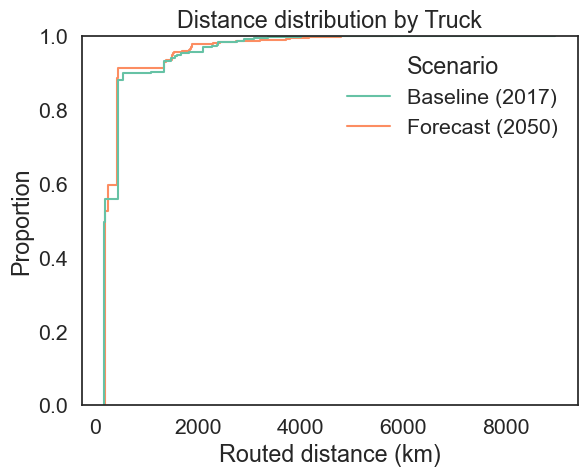

In [32]:
# plot distance
dist_by_mode_zone = pd.merge(modeled_results_by_mode_zone, 
                             tmile_results_by_mode_zone,
                            on = ['FAF', 'Mode', 'Scenario'], 
                             how = 'inner')
dist_by_mode_zone.loc[:, 'Distance'] = \
dist_by_mode_zone.loc[:, 'Ton-km'] / dist_by_mode_zone.loc[:, 'Load'] / 1000
print(dist_by_mode_zone.loc[:, 'Distance'].mean())
dist_by_mode_zone.head(5)

for mode in dist_by_mode_zone.Mode.unique():
    dist_by_mode_to_plot = dist_by_mode_zone.loc[dist_by_mode_zone['Mode'] == mode]
    ax=sns.ecdfplot(data=dist_by_mode_to_plot, x="Distance", 
                    weights = 'Load', hue="Scenario", palette = 'Set2')
    plt.title(f'Distance distribution by {mode}')
    # sns.move_legend(ax, loc="lower right")
    plt.xlabel('Routed distance (km)')
    plt.savefig(os.path.join(plot_dir, 'distance_distribution_by_' + mode + '.png'), dpi = 300, bbox_inches = 'tight' )
    
    plt.show()

3521.2236118607975


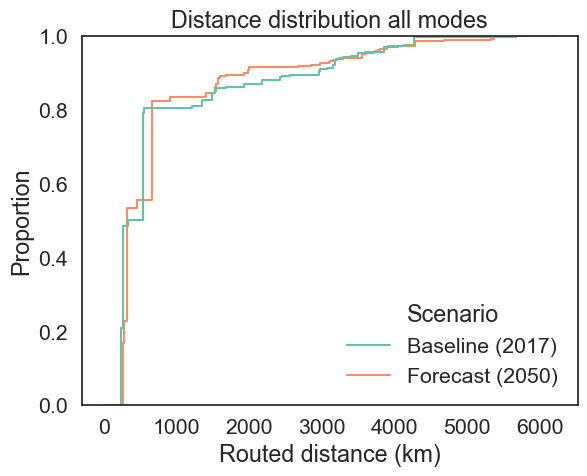

In [19]:
# # tonnage by zone
model_base_by_zone = \
gen_comm_summary(synthfirm_output_base, ['orig_FAFID'], 
                 'ShipmentLoad', 'Load', '2017',  'Baseline', add_total = False)

model_2050_by_zone = \
gen_comm_summary(synthfirm_output_2050, ['orig_FAFID'], 
                 'ShipmentLoad', 'Load', '2050', 'Forecast', add_total = False)

modeled_results_by_zone = \
pd.concat([model_base_by_zone, model_2050_by_zone])
modeled_results_by_zone.rename(columns = {'orig_FAFID': 'FAF'}, inplace = True)

tmile_base_by_zone = \
gen_comm_summary(synthfirm_output_base, 
                 ['orig_FAFID'], 'tmiles', 'Ton-km', '2017',  'Baseline', add_total = False)

tmile_2050_by_zone = \
gen_comm_summary(synthfirm_output_2050,
                 ['orig_FAFID'], 'tmiles', 'Ton-km', '2050', 'Forecast', add_total = False)

tmile_results_by_zone = \
pd.concat([tmile_base_by_zone, tmile_2050_by_zone])
tmile_results_by_zone.rename(columns = {'orig_FAFID': 'FAF'}, inplace = True)

# plot distance
dist_by_zone = pd.merge(modeled_results_by_zone, 
                        tmile_results_by_zone,
                            on = ['FAF', 'Scenario'], how = 'inner')
dist_by_zone.loc[:, 'Distance'] = dist_by_zone.loc[:, 'Ton-km'] / dist_by_zone.loc[:, 'Load'] / 1000
print(dist_by_zone.loc[:, 'Distance'].mean())


sns.ecdfplot(data=dist_by_zone, x="Distance", weights = 'Load', hue="Scenario", palette = 'Set2')
plt.title('Distance distribution all modes')
plt.xlabel('Routed distance (km)')
plt.savefig(os.path.join(plot_dir, 'distance_distribution_allmodes.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

## 3.2 FAF data processing

In [20]:
def gen_faf_summary(faf_df,  group_var, output_value, output_name, year_id, scenario, add_total = True):
    metric = output_value + "_" + year_id
    faf_by_sector = faf_df.groupby(group_var)[metric].sum()
    
    if add_total:
        faf_by_sector.loc['total'] = faf_by_sector.sum()
    faf_by_sector = faf_by_sector.reset_index()  
      
    #print(faf_by_sector.head(5))
    if output_name == 'Load':
        faf_by_sector[metric] *= us_ton_to_ton
        
    if output_name == 'Ton-km':
        unit_converter = us_ton_to_ton * miles_to_km * 1000000
        faf_by_sector[metric] *=  unit_converter # convert from million ton mile to ton-km
  
    faf_by_sector.rename(columns = {metric: output_name}, inplace = True)
    faf_by_sector.loc[:, 'Scenario'] = f'{scenario} ({year_id})'

    return(faf_by_sector)



In [21]:
trade_type_lookup = {1: 'Domestic', 2: 'Import', 3: 'Export'}
faf_inflow.loc[:, 'Type'] = \
faf_inflow.loc[:, 'trade_type'].map(trade_type_lookup)
print(faf_inflow.loc[:, 'Type'].unique())
faf_outflow.loc[:, 'Type'] = \
faf_outflow.loc[:, 'trade_type'].map(trade_type_lookup)
print(faf_outflow.loc[:, 'Type'].unique())

# tonnage production by SCTG
faf_base_prod_by_sctg = \
gen_faf_summary(faf_outflow, ['SCTG_Name'], 'tons', 'Load', 
                '2017',  'Baseline')

faf_2050_prod_by_sctg = \
gen_faf_summary(faf_outflow, ['SCTG_Name'], 'tons', 
                'Load', '2050', 'Forecast')


faf_prod_by_sctg = pd.concat([faf_base_prod_by_sctg, 
                              faf_2050_prod_by_sctg])
faf_prod_by_sctg.loc[:, 'Source'] = 'FAF5'

# tonnage production by mode
faf_base_prod_by_mode = \
gen_faf_summary(faf_outflow, ['Mode'], 'tons', 'Load', 
                '2017',  'Baseline', add_total = False)

faf_2050_prod_by_mode = \
gen_faf_summary(faf_outflow, ['Mode'], 'tons', 'Load', 
                '2050', 'Forecast', add_total = False)

faf_prod_by_mode = pd.concat([faf_base_prod_by_mode, faf_2050_prod_by_mode])
faf_prod_by_mode.loc[:, 'Source'] = 'FAF5'

# tonnage production by source
faf_base_prod_by_source = \
gen_faf_summary(faf_outflow, ['Type'], 'tons', 'Load', 
                '2017',  'Baseline', add_total = False)

faf_2050_prod_by_source = \
gen_faf_summary(faf_outflow, ['Type'], 'tons', 'Load', 
                '2050', 'Forecast', add_total = False)

faf_prod_by_source = pd.concat([faf_base_prod_by_source, faf_2050_prod_by_source])
faf_prod_by_source.loc[:, 'Source'] = 'FAF5'
faf_prod_by_source

['Domestic' 'Import' 'Export']
['Domestic' 'Import' 'Export']


Type           Load         Scenario Source
0  Domestic  130600.708368  Baseline (2017)   FAF5
1    Export   40067.025446  Baseline (2017)   FAF5
2    Import   11314.049994  Baseline (2017)   FAF5
0  Domestic  203440.970879  Forecast (2050)   FAF5
1    Export   65027.053383  Forecast (2050)   FAF5
2    Import   22610.931948  Forecast (2050)   FAF5

In [22]:
# tonnage consumption by SCTG


faf_base_cons_by_sctg = \
gen_faf_summary(faf_inflow, ['SCTG_Name'], 'tons', 'Load', 
                '2017',  'Baseline')

faf_2050_cons_by_sctg = \
gen_faf_summary(faf_inflow, ['SCTG_Name'], 'tons', 
                'Load', '2050', 'Forecast')


faf_cons_by_sctg = pd.concat([faf_base_cons_by_sctg, 
                              faf_2050_cons_by_sctg])
faf_cons_by_sctg.loc[:, 'Source'] = 'FAF5'

# tonnage consumption by mode
faf_base_cons_by_mode = \
gen_faf_summary(faf_inflow, ['Mode'], 'tons', 'Load', 
                '2017',  'Baseline', add_total = False)

faf_2050_cons_by_mode = \
gen_faf_summary(faf_inflow, ['Mode'], 'tons', 'Load', 
                '2050', 'Forecast', add_total = False)

faf_cons_by_mode = pd.concat([faf_base_cons_by_mode, faf_2050_cons_by_mode])
faf_cons_by_mode.loc[:, 'Source'] = 'FAF5'

# tonnage consumption by source
faf_base_cons_by_source = \
gen_faf_summary(faf_inflow, ['Type'], 'tons', 'Load', 
                '2017',  'Baseline', add_total = False)

faf_2050_cons_by_source = \
gen_faf_summary(faf_inflow, ['Type'], 'tons', 'Load', 
                '2050', 'Forecast', add_total = False)

faf_cons_by_source = pd.concat([faf_base_cons_by_source, faf_2050_cons_by_source])
faf_cons_by_source.loc[:, 'Source'] = 'FAF5'
faf_cons_by_source

Type           Load         Scenario Source
0  Domestic  147808.895302  Baseline (2017)   FAF5
1    Export   22651.227815  Baseline (2017)   FAF5
2    Import   17640.236970  Baseline (2017)   FAF5
0  Domestic  215173.502185  Forecast (2050)   FAF5
1    Export   37631.603629  Forecast (2050)   FAF5
2    Import   26041.273706  Forecast (2050)   FAF5

# 4 - Result visualization

## 4.1 FAF and SynthFirm comparison

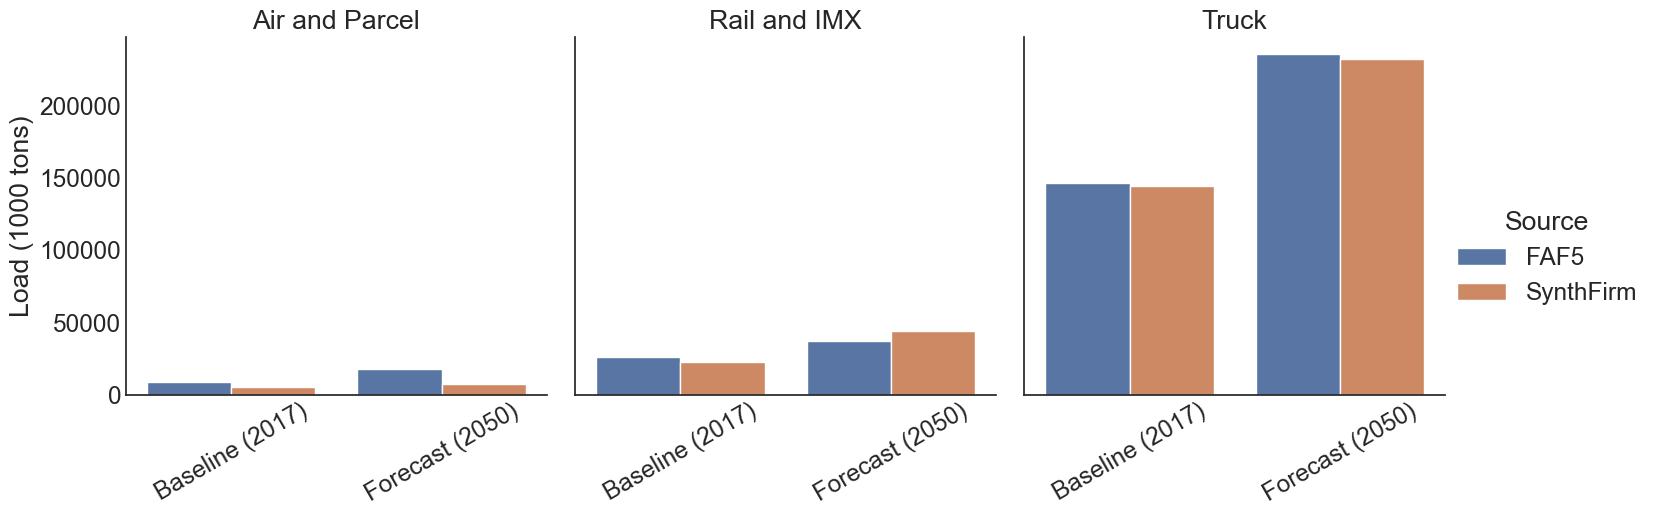

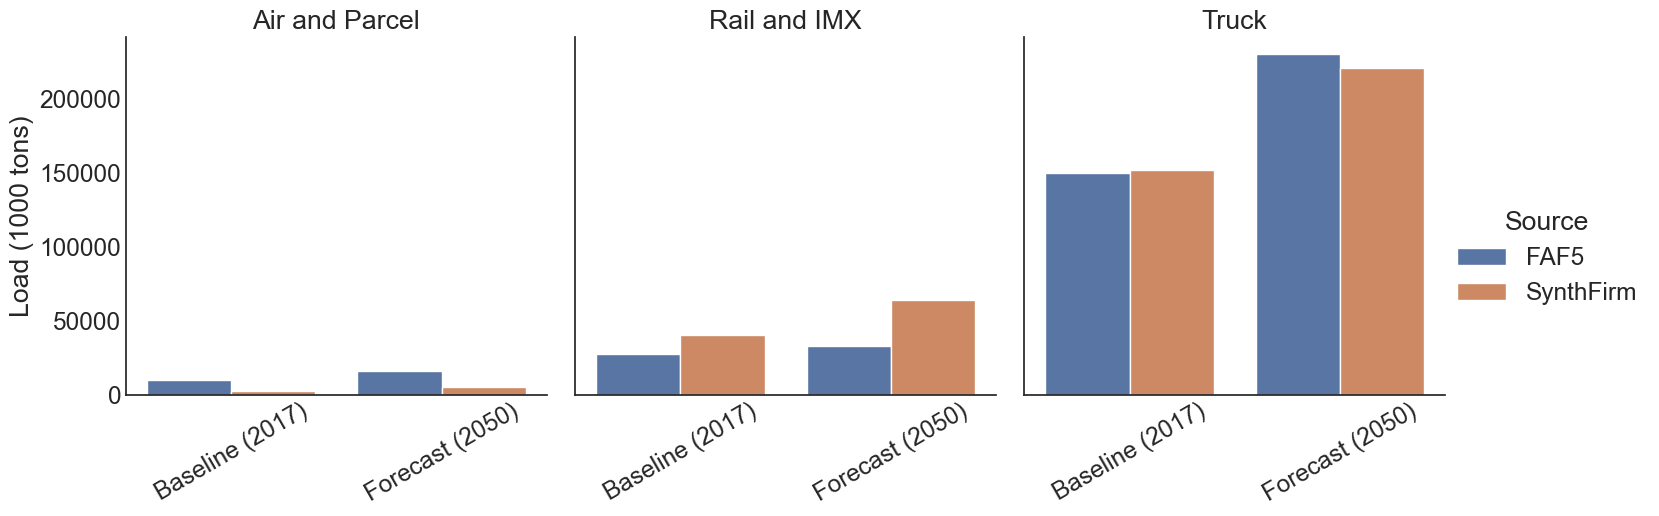

In [23]:
# compare absolute value by scenario

# mode

# production
prod_comparison_by_mode = \
pd.concat([faf_prod_by_mode, modeled_prod_by_mode])

sns.set(font_scale=1.6)
plt.style.use('seaborn-v0_8-white')
sns.set_style("white")
ax = sns.catplot(prod_comparison_by_mode, x = 'Scenario', hue = 'Source', y = 'Load',col = 'Mode', kind = 'bar')
ax.set_titles("{col_name}")
ax.set_axis_labels(y_var='Load (1000 tons)')
for axn in ax.axes.flat:
    axn.set_xlabel('')
    for label in axn.get_xticklabels():
        label.set_rotation(30)
plt.savefig(os.path.join(plot_dir, 'production_comparison_by_mode.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

# consumption
cons_comparison_by_mode = \
pd.concat([faf_cons_by_mode, modeled_cons_by_mode])

sns.set(font_scale=1.6)
plt.style.use('seaborn-v0_8-white')
sns.set_style("white")
ax = sns.catplot(cons_comparison_by_mode, x = 'Scenario', hue = 'Source', y = 'Load',col = 'Mode', kind = 'bar')
ax.set_titles("{col_name}")
ax.set_axis_labels(y_var='Load (1000 tons)')
for axn in ax.axes.flat:
    axn.set_xlabel('')
    for label in axn.get_xticklabels():
        label.set_rotation(30)
plt.savefig(os.path.join(plot_dir, 'consumption_comparison_by_mode.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

In [23]:
cons_comparison_by_mode

Mode           Load         Scenario     Source
0  Air and Parcel    9322.013188  Baseline (2017)       FAF5
1    Rail and IMX   25261.512725  Baseline (2017)       FAF5
2           Truck  136058.299252  Baseline (2017)       FAF5
0  Air and Parcel   14756.494572  Forecast (2050)       FAF5
1    Rail and IMX   29700.304233  Forecast (2050)       FAF5
2           Truck  208508.454000  Forecast (2050)       FAF5
0  Air and Parcel    2360.758309  Baseline (2017)  SynthFirm
1    Rail and IMX   36386.476118  Baseline (2017)  SynthFirm
2           Truck  137499.425665  Baseline (2017)  SynthFirm
0  Air and Parcel    3365.464042  Forecast (2050)  SynthFirm
1    Rail and IMX   43338.836974  Forecast (2050)  SynthFirm
2           Truck  186954.138686  Forecast (2050)  SynthFirm

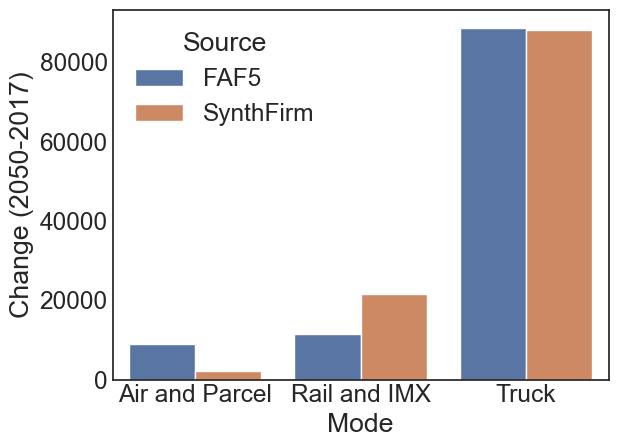

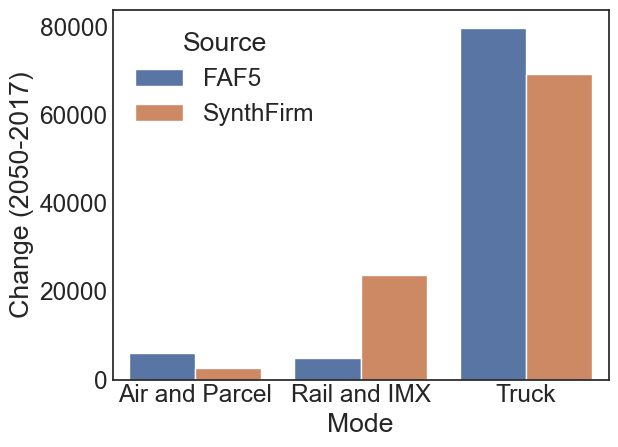

In [24]:
delta_production_by_mode = pd.pivot_table(prod_comparison_by_mode, 
                                          index = ['Mode', 'Source'],
                                         columns = 'Scenario', 
                                          values = 'Load', 
                                          aggfunc = 'sum').reset_index()

delta_production_by_mode.loc[:, 'Change (2050-2017)'] = \
delta_production_by_mode.loc[:, 'Forecast (2050)'] - \
delta_production_by_mode.loc[:, 'Baseline (2017)']

ax = sns.barplot(delta_production_by_mode, x = 'Mode', 
                 hue = 'Source', y = 'Change (2050-2017)')

plt.savefig(os.path.join(plot_dir, 'delta_prod_comparison_by_mode.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

delta_consumption_by_mode = pd.pivot_table(cons_comparison_by_mode, 
                                          index = ['Mode', 'Source'],
                                         columns = 'Scenario', 
                                          values = 'Load', 
                                          aggfunc = 'sum').reset_index()

delta_consumption_by_mode.loc[:, 'Change (2050-2017)'] = \
delta_consumption_by_mode.loc[:, 'Forecast (2050)'] - \
delta_consumption_by_mode.loc[:, 'Baseline (2017)']

ax = sns.barplot(delta_consumption_by_mode, x = 'Mode', 
                 hue = 'Source', y = 'Change (2050-2017)')

plt.savefig(os.path.join(plot_dir, 'delta_cons_comparison_by_mode.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

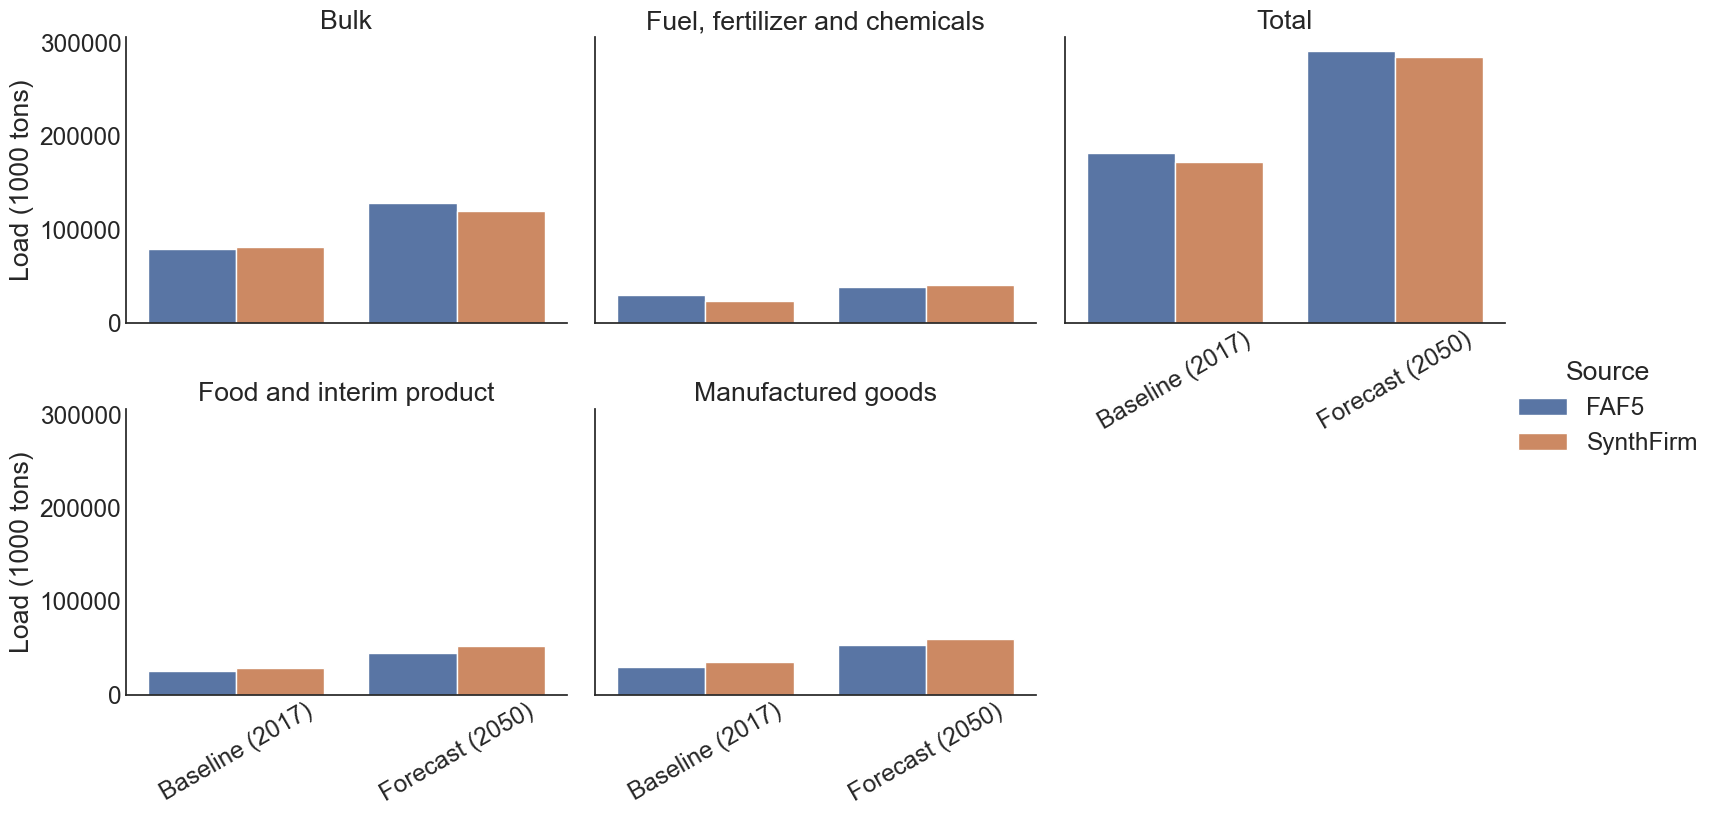

In [25]:
# SCTG

# production
prod_comparison_by_sctg = \
pd.concat([faf_prod_by_sctg, modeled_prod_by_sctg])

prod_comparison_by_sctg = \
prod_comparison_by_sctg.loc[prod_comparison_by_sctg['SCTG_Name'] != 'other']
commodity_label['total'] = 'Total'
prod_comparison_by_sctg.loc[:, 'Commodity'] = \
prod_comparison_by_sctg.loc[:, 'SCTG_Name'].map(commodity_label)

sns.set(font_scale=1.6)
plt.style.use('seaborn-v0_8-white')
sns.set_style("white")

col_orders = ['Bulk', 'Fuel, fertilizer and chemicals', 'Total', 'Food and interim product',  'Manufactured goods']
ax = sns.catplot(prod_comparison_by_sctg, x = 'Scenario', hue = 'Source', y = 'Load',col = 'Commodity',
                col_wrap = 3, col_order = col_orders, kind = 'bar', height = 4, aspect = 1.3)
ax.set_titles("{col_name}")
ax.set_axis_labels(y_var='Load (1000 tons)')
for axn in ax.axes.flat:
    axn.set_xlabel('')
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# sns.move_legend(ax, "lower right", bbox_to_anchor=(0.8, 0.1))
plt.savefig(os.path.join(plot_dir, 'prod_comparison_by_sctg.png'), dpi = 300, bbox_inches = 'tight')
plt.show()


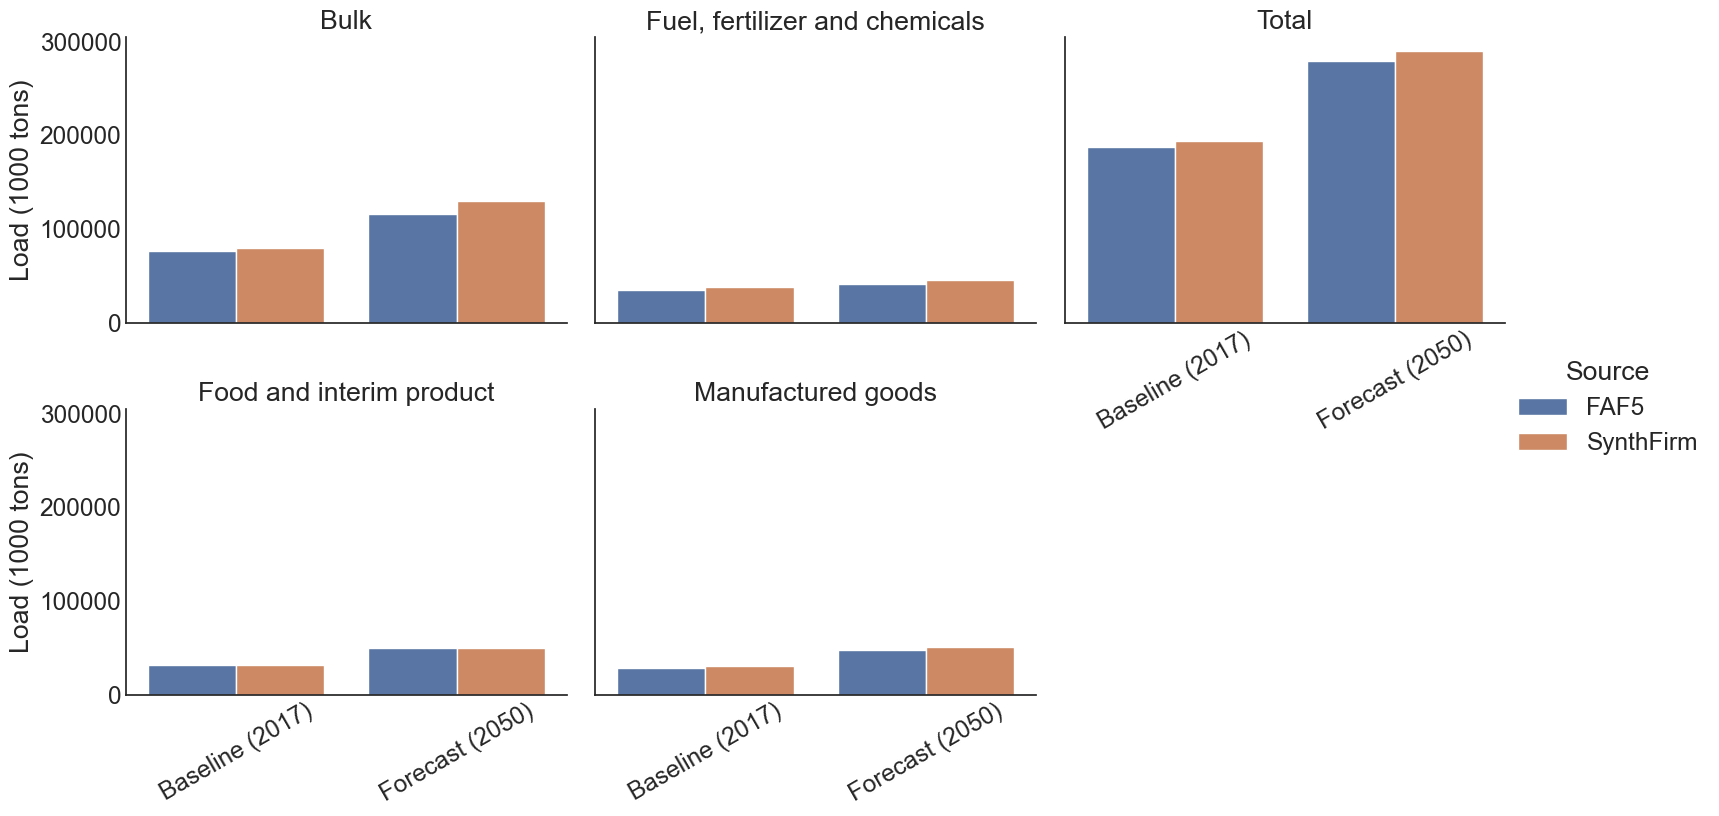

In [26]:
# consumption
cons_comparison_by_sctg = \
pd.concat([faf_cons_by_sctg, modeled_cons_by_sctg])

cons_comparison_by_sctg = \
cons_comparison_by_sctg.loc[cons_comparison_by_sctg['SCTG_Name'] != 'other']
commodity_label['total'] = 'Total'
cons_comparison_by_sctg.loc[:, 'Commodity'] = \
cons_comparison_by_sctg.loc[:, 'SCTG_Name'].map(commodity_label)


col_orders = ['Bulk', 'Fuel, fertilizer and chemicals', 'Total', 'Food and interim product',  'Manufactured goods']
ax = sns.catplot(cons_comparison_by_sctg, x = 'Scenario', hue = 'Source', y = 'Load',col = 'Commodity',
                col_wrap = 3, col_order = col_orders, kind = 'bar', height = 4, aspect = 1.3)
ax.set_titles("{col_name}")
ax.set_axis_labels(y_var='Load (1000 tons)')
for axn in ax.axes.flat:
    axn.set_xlabel('')
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# sns.move_legend(ax, "lower right", bbox_to_anchor=(0.8, 0.1))
plt.savefig(os.path.join(plot_dir, 'cons_comparison_by_sctg.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

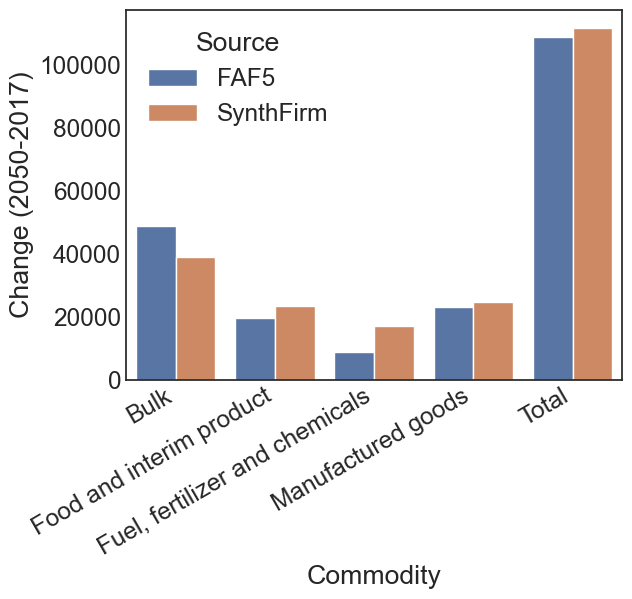

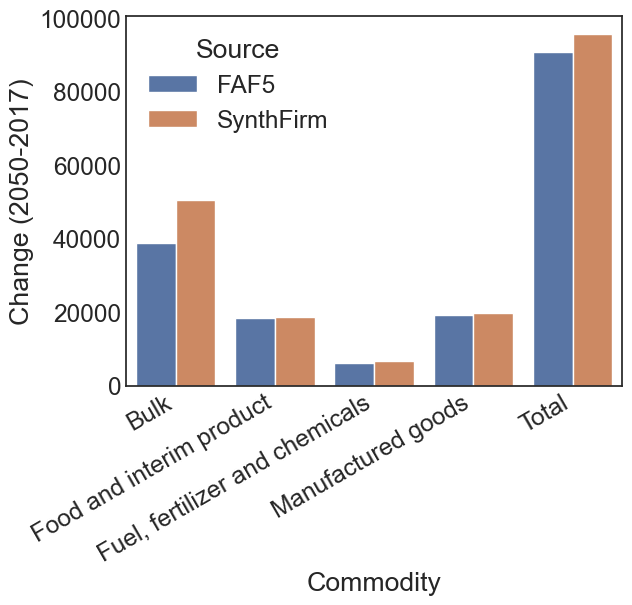

In [27]:
delta_prod_by_sctg = pd.pivot_table(prod_comparison_by_sctg, 
                                    index = ['Commodity', 'Source'],
                                         columns = 'Scenario', values = 'Load', aggfunc = 'sum').reset_index()

delta_prod_by_sctg.loc[:, 'Change (2050-2017)'] = \
delta_prod_by_sctg.loc[:, 'Forecast (2050)'] - \
delta_prod_by_sctg.loc[:, 'Baseline (2017)']

ax = sns.barplot(delta_prod_by_sctg, x = 'Commodity', 
                 hue = 'Source', y = 'Change (2050-2017)')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(plot_dir, 'delta_prod_comparison_by_sctg.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

delta_cons_by_sctg = pd.pivot_table(cons_comparison_by_sctg,
                                    index = ['Commodity', 'Source'],
                                    columns = 'Scenario', 
                                    values = 'Load', 
                                    aggfunc = 'sum').reset_index()

delta_cons_by_sctg.loc[:, 'Change (2050-2017)'] = \
delta_cons_by_sctg.loc[:, 'Forecast (2050)'] - \
delta_cons_by_sctg.loc[:, 'Baseline (2017)']

ax = sns.barplot(delta_cons_by_sctg, x = 'Commodity', 
                 hue = 'Source', y = 'Change (2050-2017)')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(plot_dir, 'delta_cons_comparison_by_sctg.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

## 4.2 Visualization of SynthFirm results

### base distribution

In [29]:
# define map plot by county
def plot_region_map(region_gdf, column, title,
                    filename, logscale = True, add_basemap = True,
                    vmin=0, vmax=50, legend_scale = 0.8, 
                    alpha=0.5, cmap='viridis'):
    """
    Plots a choropleth map of firm density and adds a basemap.
    
    Parameters:
        region_gdf: GeoDataFrame
            The geodataframe with polygon regions and firm attr column.
        column: str
            Name of the column for density.
        filename: str
            Output filename.
        logscale: boolean
            If use logscale for color ramp
        vmin, vmax: float
            Color scale min and max.
        alpha: float
            Polygon alpha.
        cmap: str
            Colormap.
    """
    if cmap == 'viridis':
        facecolor ='#440154'
    else:
        facecolor = 'None'
    sns.set(font_scale=1.2)
    ax = region_gdf.plot(facecolor=facecolor, linewidth = 0.001)
    if logscale is True:
        region_gdf.plot(
            figsize=(6, 4.5),
            ax=ax,
            column=column,
            norm=matplotlib.colors.LogNorm(vmin=0.001, vmax=vmax),
            alpha=alpha,
            legend=True,
            cmap=cmap,
            linewidth=0.001,
            legend_kwds={'shrink': legend_scale},
            edgecolor='none'
        )
    else:
        region_gdf.plot(
            figsize=(6, 4.5),
            ax = ax,
            column=column,
            vmin=vmin, vmax=vmax,
            alpha=alpha,
            legend=True,
            cmap=cmap,
            linewidth=0.001,
            legend_kwds={'shrink': legend_scale},
            edgecolor='none')
    if add_basemap:
        cx.add_basemap(ax, crs=region_gdf.crs.to_string() if region_gdf.crs else 'EPSG:4326', 
                   source=cx.providers.CartoDB.Positron)
    ax.grid(False)
    ax.axis('off')
    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [30]:
production_by_sctg_base.drop(columns = ['area'], inplace = True)
consumption_by_sctg_base.drop(columns = ['area'], inplace = True)

production_by_sctg_2050.drop(columns = ['area'], inplace = True)
consumption_by_sctg_2050.drop(columns = ['area'], inplace = True)

2050_prod interm_food


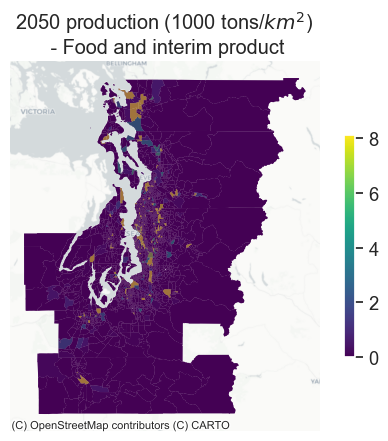

2050_prod bulk


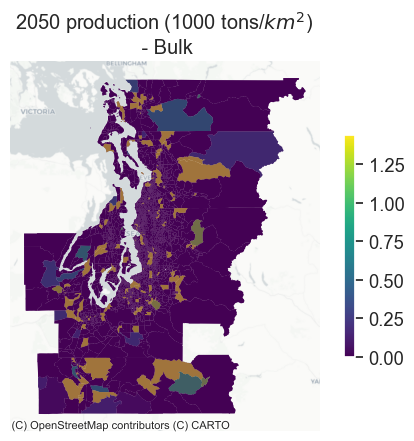

2050_prod mfr_goods


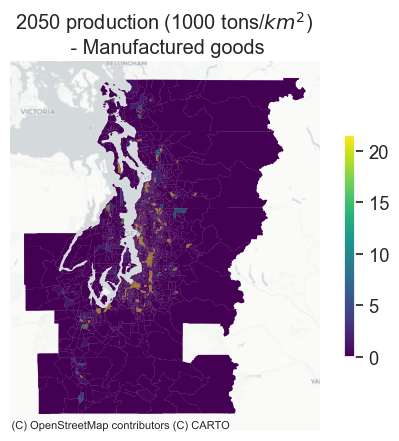

2050_prod fuel_fert


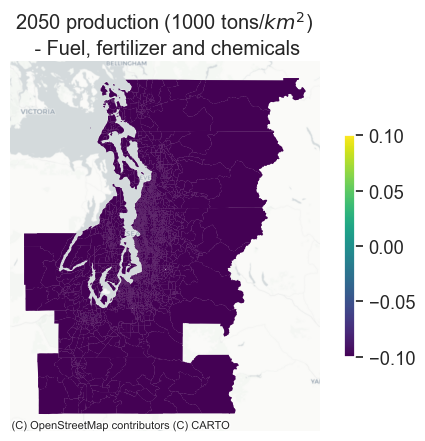

2050_prod total


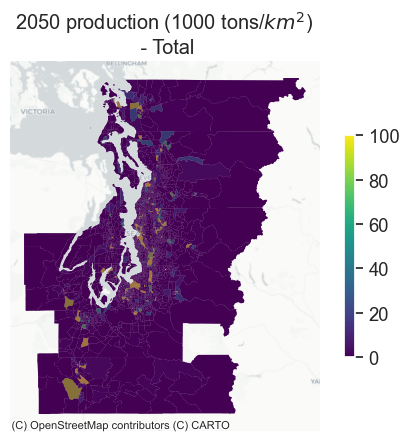

2050_cons interm_food


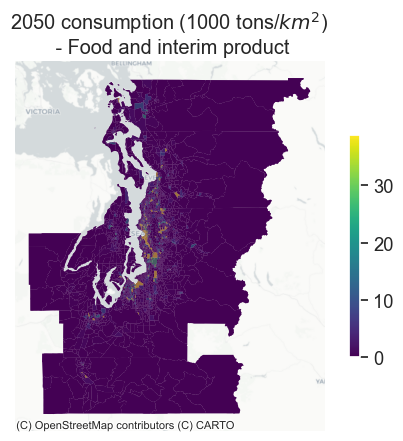

2050_cons bulk


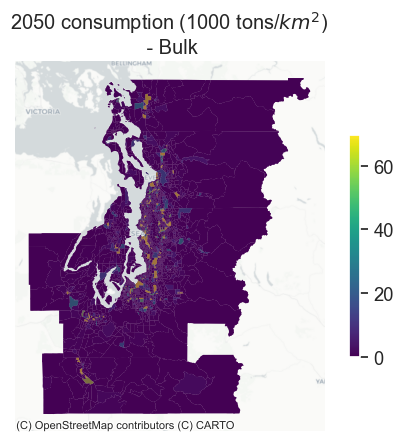

2050_cons mfr_goods


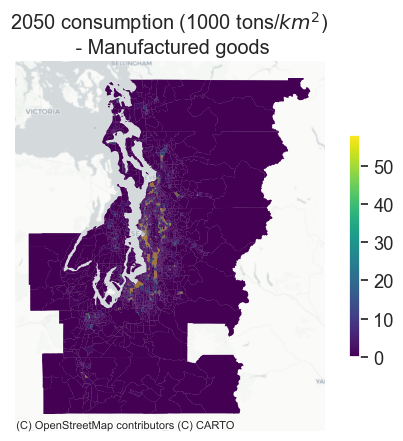

2050_cons fuel_fert


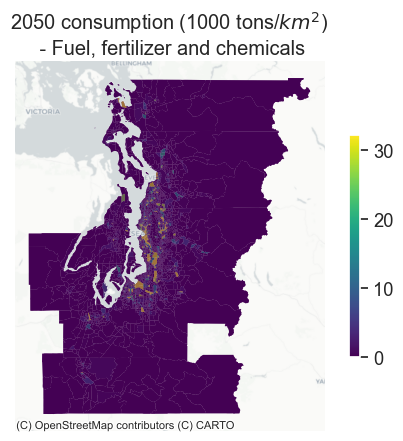

2050_cons total


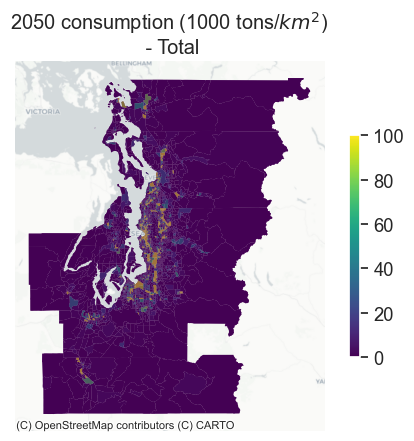

In [31]:
# baseline map by SCTG
region_map_sel = region_map.loc[region_map['FAFID'] == focus_region]
region_map_with_cf = \
region_map_sel.merge(production_by_sctg_2050, 
                 on = 'MESOZONE', how='left')

region_map_with_cf = \
region_map_with_cf.merge(consumption_by_sctg_2050, 
                         on = 'MESOZONE', how='left')

var_to_plot = ['2050_prod_interm_food_per_area', '2050_prod_bulk_per_area',
       '2050_prod_mfr_goods_per_area', '2050_prod_fuel_fert_per_area',
       '2050_prod_total_per_area',
       '2050_cons_interm_food_per_area', '2050_cons_bulk_per_area',
       '2050_cons_mfr_goods_per_area', '2050_cons_fuel_fert_per_area',
       '2050_cons_total_per_area']

metric_lookup = {'2050_prod': '2050 production',
                 '2050_cons': '2050 consumption'}

def name_parcer(s):
    words = s.split('_')
    if len(words) <= 4:
        SCTG_Group =  ''  # Not enough words to remove
        prefix = ''
    else:
        SCTG_Group = '_'.join(words[2:-2])  
        prefix = '_'.join(words[0:2])
    return prefix, SCTG_Group  

unit = '1000 tons/$km^{2}$'
# Apply the function
for var in var_to_plot:
    prefix, SCTG_group = name_parcer(var)
    
    print(prefix, SCTG_group)
    title_prefix = metric_lookup[prefix]
    if SCTG_group == 'total':
        title = f'{title_prefix} ({unit}) \n - Total'
        vmax = 100
    else:
        commodity = commodity_label[SCTG_group]
        title = f'{title_prefix} ({unit}) \n - {commodity}'
        vmax = 1.05 * region_map_with_cf[var].quantile(0.95)
    filename = os.path.join(plot_dir, prefix + '_' + SCTG_group + '_by_zone.png')
    plot_region_map(region_map_with_cf, var, title,
                    filename, logscale = False, 
                    vmin=0, vmax=vmax, legend_scale = 0.6, alpha=0.5, cmap='viridis')

In [32]:
production_by_mode_base.drop(columns = ['area'], inplace = True)
consumption_by_mode_base.drop(columns = ['area'], inplace = True)

2050_prod Truck


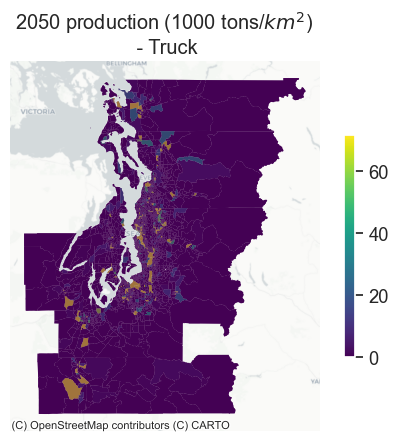

2050_prod Rail and IMX


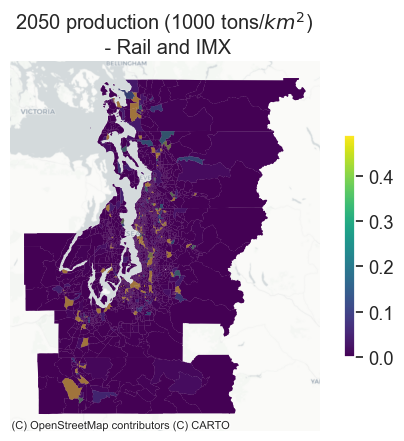

2050_prod Air and Parcel


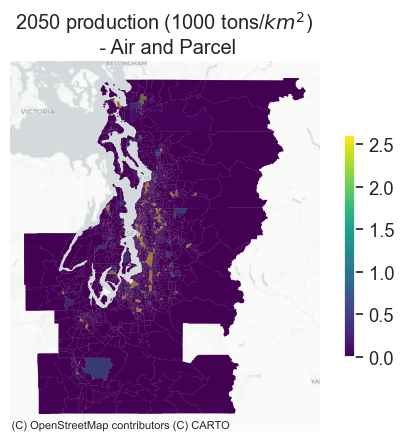

2050_cons Truck


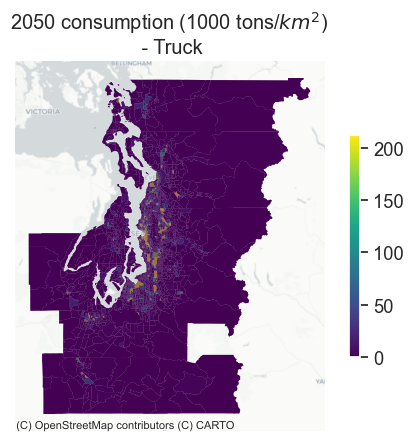

2050_cons Rail and IMX


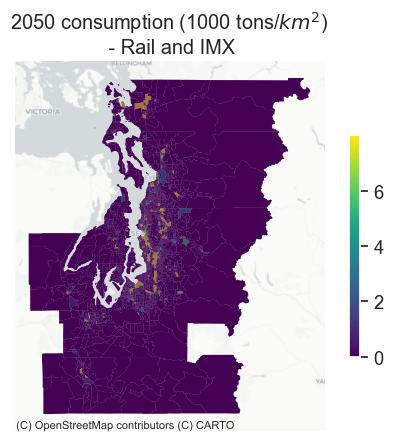

2050_cons Air and Parcel


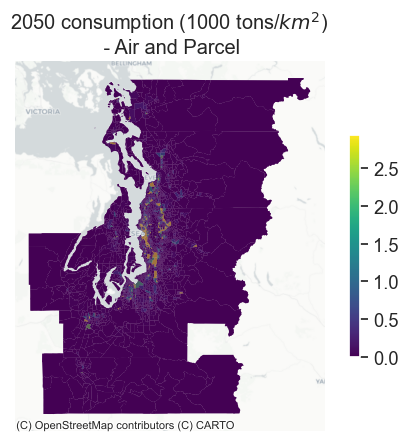

In [33]:
# baseline map by mode
region_map_with_cf = \
region_map.merge(production_by_mode_2050, 
                 on = 'MESOZONE', how='left')

region_map_with_cf = \
region_map_with_cf.merge(consumption_by_mode_2050, 
                         on = 'MESOZONE', how='left')

# print(region_map_with_cf.columns)
var_to_plot = ['2050_prod_Truck_per_area',
       '2050_prod_Rail and IMX_per_area', 
               '2050_prod_Air and Parcel_per_area',
       '2050_cons_Truck_per_area', 
               '2050_cons_Rail and IMX_per_area',
       '2050_cons_Air and Parcel_per_area']



unit = '1000 tons/$km^{2}$'
# Apply the function
for var in var_to_plot:
    prefix, mode = name_parcer(var)
    
    print(prefix, mode)
    title_prefix = metric_lookup[prefix]
    title = f'{title_prefix} ({unit}) \n - {mode}'
    vmax = 1.05 * region_map_with_cf[var].quantile(0.95)
    filename = os.path.join(plot_dir, prefix + '_' + mode + '_by_zone.png')
    plot_region_map(region_map_with_cf, var, title,
                    filename, logscale = False, 
                    vmin=0, vmax=vmax, legend_scale = 0.6, alpha=0.5, cmap='viridis')

### base versus disruption

In [34]:
# scenario: left - right
plot_pairs = {'Production change (2050-2017)': ('2050_prod_', '2017_prod_'),
             'Consumption change (2050-2017)': ('2050_cons_', '2017_cons_')}

output_prefix = {'Production change (2050-2017)': 'prod_delta_2050_2017_',
             'Consumption change (2050-2017)': 'cons_delta_2050_2017_'}

unit = '1000 tons/$km^{2}$'

In [35]:
production_by_sctg_base.drop(columns = ['FAFID','CBPZONE', 'GEOID'], inplace = True)  
production_by_sctg_2050.drop(columns = ['FAFID','CBPZONE', 'GEOID'], inplace = True)  
consumption_by_sctg_base.drop(columns = ['FAFID','CBPZONE', 'GEOID'], inplace = True)  
consumption_by_sctg_2050.drop(columns = ['FAFID','CBPZONE', 'GEOID'], inplace = True) 

In [36]:
# generate dataset

commodity_change_comparison = \
region_map.merge(production_by_sctg_base,
                 on = ['MESOZONE'], how = 'left')

commodity_change_comparison = \
commodity_change_comparison.merge(production_by_sctg_2050,
                                  on = ['MESOZONE'], how = 'left')

commodity_change_comparison = \
commodity_change_comparison.merge(consumption_by_sctg_base, 
                                     on = ['MESOZONE'], how = 'left')

commodity_change_comparison = \
commodity_change_comparison.merge(consumption_by_sctg_2050,
                                     on = ['MESOZONE'], how = 'left')

commodity_change_comparison.head(5)

GEOID  FAFID      MESOZONE  CBPZONE  \
0  530330293053    531  530330293053    53033   
1  530330205002    531  530330205002    53033   
2  530530620003    531  530530620003    53053   
3  530530613002    531  530530613002    53053   
4  530610527055    531  530610527055    53061   

                                            geometry      area  \
0  MULTIPOLYGON (((-122.21292 47.42784, -122.2129...  0.891907   
1  MULTIPOLYGON (((-122.31347 47.75749, -122.3085...  0.435127   
2  MULTIPOLYGON (((-122.42101 47.23054, -122.4164...  0.291051   
3  MULTIPOLYGON (((-122.46102 47.25418, -122.4538...  0.254453   
4  MULTIPOLYGON (((-122.1409 48.04966, -122.14089...  0.595708   

   2017_prod_mfr_goods_per_area  2017_prod_interm_food_per_area  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   2017_prod_fuel_fert_per_area  2017_prod_bulk_per_area  ...  \
0                           0.0                      0.0  ...   
1                           0.0                      0.0  ...   
2                           0.0                      0.0  ...   
3                           0.0                      0.0  ...   
4                           0.0                      0.0  ...   

   2017_cons_bulk_per_area  2017_cons_other_per_area  \
0                      0.0                       0.0   
1                      0.0                       0.0   
2                      0.0                       0.0   
3                      0.0                       0.0   
4                      0.0                       0.0   

   2017_cons_fuel_fert_per_area  2017_cons_total_per_area  \
0                      0.000000                  1.564373   
1                      0.150073                  1.609091   
2                      1.869222                  2.490917   
3                     28.357956                 39.200677   
4                      0.000000                  0.000000   

   2050_cons_mfr_goods_per_area  2050_cons_interm_food_per_area  \
0                      3.851699                        0.000000   
1                      0.680480                        0.613052   
2                      0.062882                        0.000000   
3                      0.547554                        2.747547   
4                      0.000000                        0.000000   

   2050_cons_other_per_area  2050_cons_fuel_fert_per_area  \
0                       0.0                        0.0000   
1                       0.0                        0.0000   
2                       0.0                        0.0000   
3                       0.0                        2.3789   
4                       0.0                        0.0000   

   2050_cons_bulk_per_area  2050_cons_total_per_area  
0                      0.0                  3.851699  
1                      0.0                  1.293531  
2                      0.0                  0.062882  
3                      0.0                  5.674000  
4                      0.0                  0.000000  

[5 rows x 30 columns]

Production change (2050-2017) mfr_goods


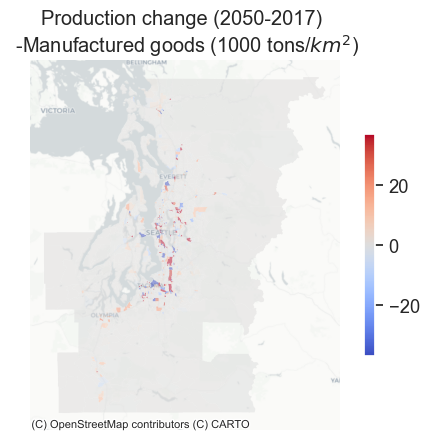

Production change (2050-2017) interm_food


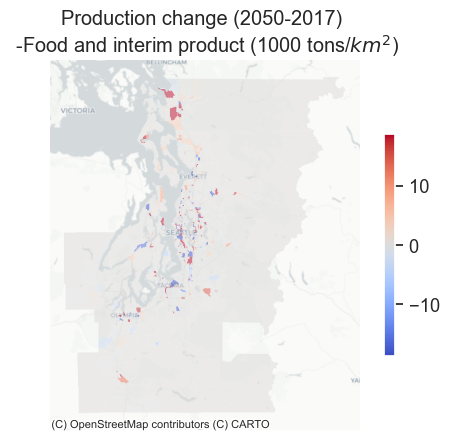

Production change (2050-2017) bulk


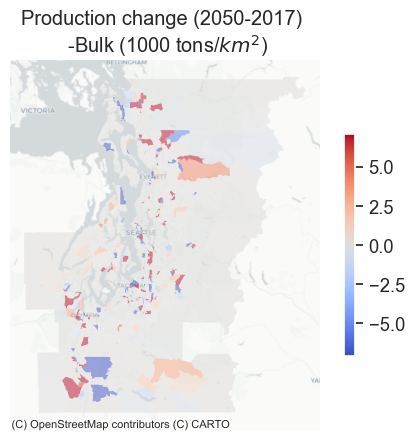

Production change (2050-2017) fuel_fert


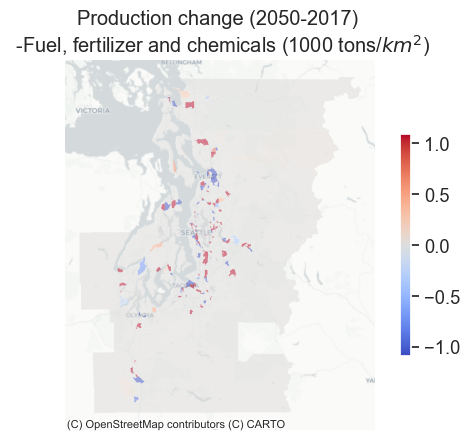

Production change (2050-2017) total


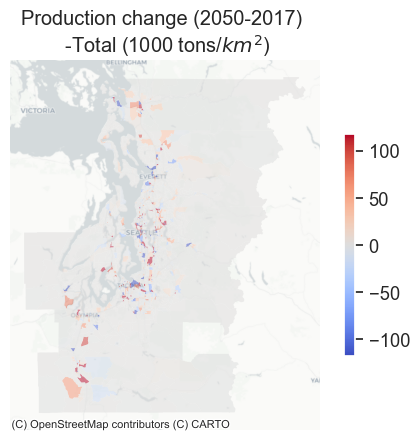

Consumption change (2050-2017) mfr_goods


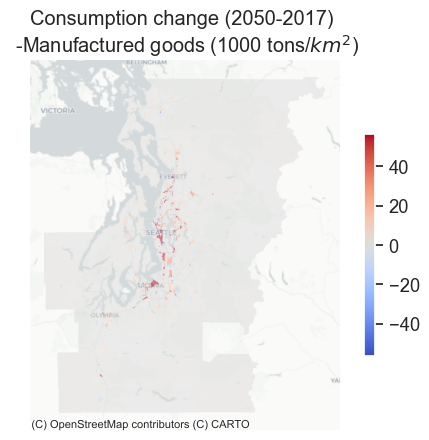

Consumption change (2050-2017) interm_food


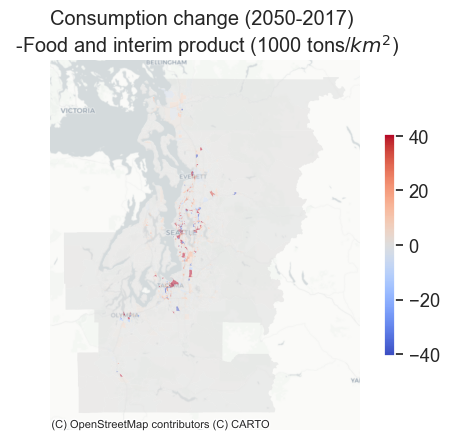

Consumption change (2050-2017) bulk


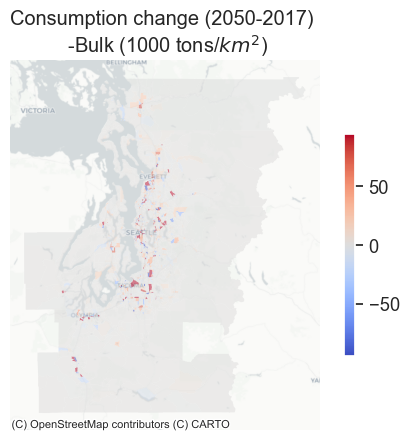

Consumption change (2050-2017) fuel_fert


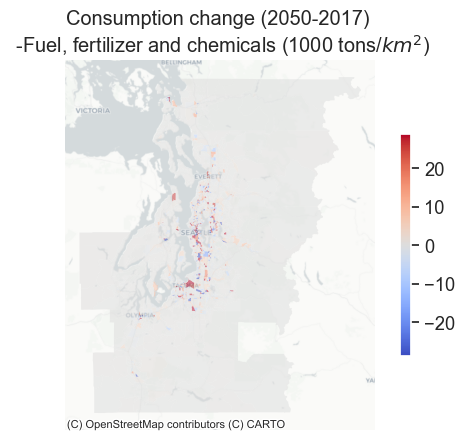

Consumption change (2050-2017) total


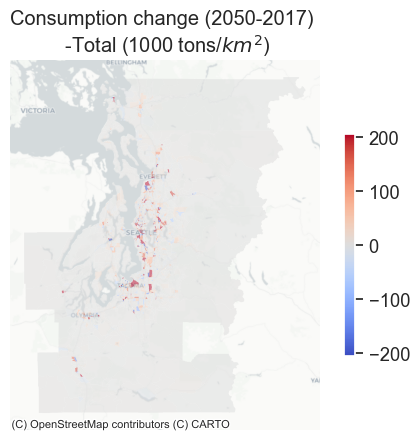

In [37]:

## delta map by sctg

col_groups = synthfirm_output_base['SCTG_Name'].unique().tolist()
col_groups.append('total')

commodity_label['total'] = 'Total'

# upper_bound_lookup = {'bulk': 0.5, 'fuel_fert': 0.3,
#                   'interm_food': 0.1, 'mfr_goods': 0.5,
#                   'total':1}

for plot_pair in plot_pairs.keys():
    output_attr = plot_pair
    left_prefix, right_prefix = plot_pairs[plot_pair]
    
    for attr in col_groups:
        if attr == 'other':
            continue
        # production
        alt_attr = left_prefix + attr + '_per_area'
        base_attr = right_prefix + attr + '_per_area'
        delta_attr = output_attr + '-' +  attr
        print(plot_pair, attr)

        percent_delta_attr = 'Percent ' + output_attr + '-' + attr
        
        commodity_change_comparison.loc[:, delta_attr] = \
        commodity_change_comparison.loc[:, alt_attr] -\
        commodity_change_comparison.loc[:, base_attr]

        commodity_change_comparison.loc[:, percent_delta_attr] = \
        commodity_change_comparison.loc[:, delta_attr] /\
        commodity_change_comparison.loc[:, base_attr] * 100
        
        commodity_change_comparison.fillna(0, inplace = True)
        
        # commodity_change_comparison.loc[:, percent_delta_attr].replace(-np.inf, -100, inplace = True)
        # commodity_change_comparison.loc[:, percent_delta_attr].replace(np.inf, 100, inplace = True)
        # commodity_change_comparison.loc[commodity_change_comparison[percent_delta_attr]>100, percent_delta_attr] = 100
        # commodity_change_comparison.loc[commodity_change_comparison[percent_delta_attr]<-100, percent_delta_attr] = -100

        upper_bound = commodity_change_comparison[delta_attr].quantile(0.975)
        lower_bound = commodity_change_comparison[delta_attr].quantile(0.025)
        upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
        # upper_bound = upper_bound_lookup[attr]
        lower_bound = -upper_bound
        
        file_prefix = output_prefix[plot_pair]
        filename = os.path.join(plot_dir, file_prefix + '_' + attr + '_by_zone.png')
        commodity = commodity_label[attr]
        title = f'{plot_pair} \n -{commodity} ({unit})'
        plot_region_map(commodity_change_comparison, delta_attr, title,
                    filename, logscale = False, 
                    vmin=lower_bound, vmax=upper_bound, legend_scale = 0.6, alpha=0.5, cmap='coolwarm')
        # title = f'Percent {plot_pair} \n -{commodity} (%)'
        # filename = os.path.join(plot_dir, 'Percent_' + file_prefix + '_' + attr + '_by_zone.png')
        # plot_region_map(commodity_change_comparison, percent_delta_attr, title,
        #             filename, logscale = False, 
        #             vmin=-100, vmax=100, legend_scale = 0.6, alpha=0.5, cmap='coolwarm')

In [39]:
# generate dataset
production_by_mode_base.drop(columns = ['FAFID', 'CBPZONE', 'GEOID'], inplace = True)  
production_by_mode_2050.drop(columns = ['FAFID', 'CBPZONE', 'GEOID'], inplace = True)  
consumption_by_mode_base.drop(columns = ['FAFID', 'CBPZONE', 'GEOID'], inplace = True)  
consumption_by_mode_2050.drop(columns = ['FAFID', 'CBPZONE', 'GEOID'], inplace = True)  

commodity_change_comparison_mode = \
region_map_sel.merge(production_by_mode_base, 
                 on = ['MESOZONE'], how = 'left')

commodity_change_comparison_mode = \
commodity_change_comparison_mode.merge(production_by_mode_2050,
                                       on = ['MESOZONE'], how = 'left')

commodity_change_comparison_mode = \
commodity_change_comparison_mode.merge(consumption_by_mode_base,
                                     on = ['MESOZONE'], how = 'left')

commodity_change_comparison_mode = \
commodity_change_comparison_mode.merge(consumption_by_mode_2050, 
                                     on = ['MESOZONE'], how = 'left')

commodity_change_comparison_mode.head(5)

GEOID  FAFID      MESOZONE  CBPZONE  \
0  530330293053    531  530330293053    53033   
1  530330205002    531  530330205002    53033   
2  530530620003    531  530530620003    53053   
3  530530613002    531  530530613002    53053   
4  530610527055    531  530610527055    53061   

                                            geometry    area_x  \
0  MULTIPOLYGON (((-122.21292 47.42784, -122.2129...  0.891907   
1  MULTIPOLYGON (((-122.31347 47.75749, -122.3085...  0.435127   
2  MULTIPOLYGON (((-122.42101 47.23054, -122.4164...  0.291051   
3  MULTIPOLYGON (((-122.46102 47.25418, -122.4538...  0.254453   
4  MULTIPOLYGON (((-122.1409 48.04966, -122.14089...  0.595708   

   2017_prod_Air and Parcel_per_area  2017_prod_Truck_per_area  \
0                                0.0                       0.0   
1                                0.0                       0.0   
2                                0.0                       0.0   
3                                0.0                       0.0   
4                                0.0                       0.0   

   2017_prod_Rail and IMX_per_area  2017_prod_total_per_area  ...  \
0                              0.0                       0.0  ...   
1                              0.0                       0.0  ...   
2                              0.0                       0.0  ...   
3                              0.0                       0.0  ...   
4                              0.0                       0.0  ...   

   2050_prod_total_per_area  2017_cons_Air and Parcel_per_area  \
0                       0.0                           0.005075   
1                       0.0                           0.067357   
2                       0.0                           0.000000   
3                       0.0                           0.012591   
4                       0.0                           0.000000   

   2017_cons_Truck_per_area  2017_cons_Rail and IMX_per_area  \
0                  1.556407                         0.002890   
1                  1.541733                         0.000000   
2                  2.454065                         0.036852   
3                 35.249166                         3.938920   
4                  0.000000                         0.000000   

   2017_cons_total_per_area      area  2050_cons_Air and Parcel_per_area  \
0                  1.564373  0.891907                           0.000882   
1                  1.609091  0.435127                           0.050066   
2                  2.490917  0.291051                           0.000000   
3                 39.200677  0.254453                           0.138804   
4                  0.000000  0.595708                           0.000000   

   2050_cons_Truck_per_area  2050_cons_Rail and IMX_per_area  \
0                  3.830599                         0.020219   
1                  1.241414                         0.002051   
2                  0.062882                         0.000000   
3                  5.490911                         0.044285   
4                  0.000000                         0.000000   

   2050_cons_total_per_area  
0                  3.851699  
1                  1.293531  
2                  0.062882  
3                  5.674000  
4                  0.000000  

[5 rows x 24 columns]

Production change (2050-2017) Air and Parcel


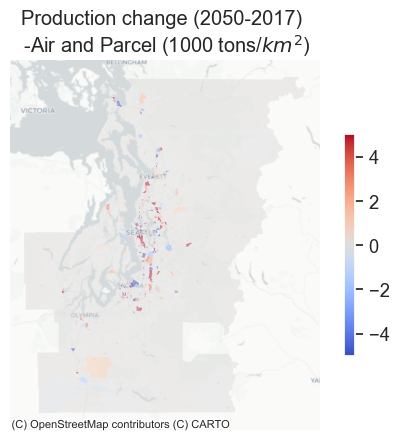

Production change (2050-2017) Truck


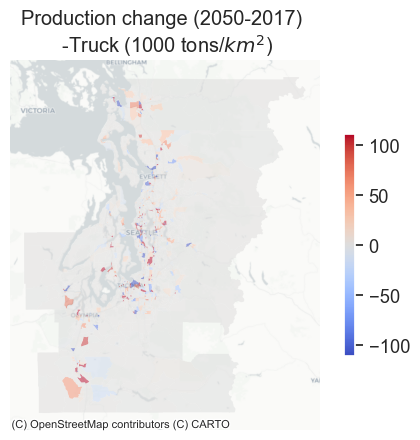

Production change (2050-2017) Rail and IMX


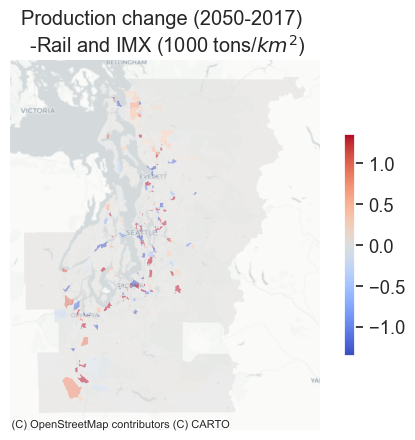

Consumption change (2050-2017) Air and Parcel


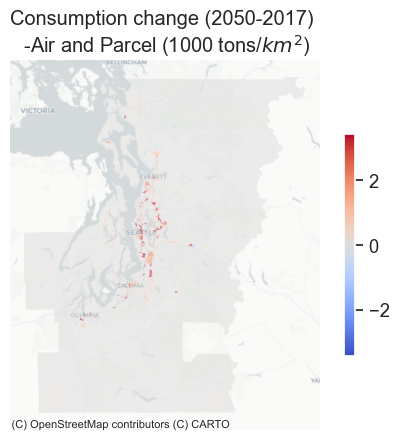

Consumption change (2050-2017) Truck


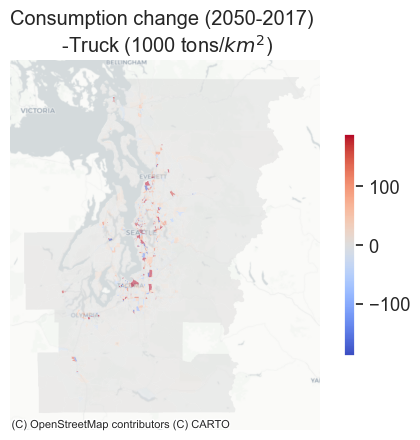

Consumption change (2050-2017) Rail and IMX


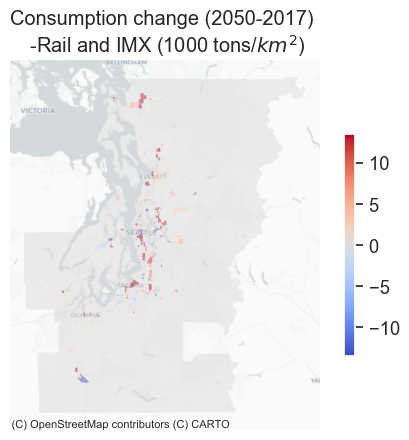

In [40]:
# delta by mode
modes = ['Air and Parcel', 'Truck', 'Rail and IMX']
# upper_bound_lookup_mode = {'Truck':0.5, 'Rail and IMX':0.4, 'Air and Parcel':0.005}
for plot_pair in plot_pairs.keys():
    output_attr = plot_pair
    left_prefix, right_prefix = plot_pairs[plot_pair]
    
    for mode in modes:

        # production
        alt_attr = left_prefix + mode + '_per_area'
        base_attr = right_prefix + mode + '_per_area'
        delta_attr = output_attr + '-' +  mode
        print(plot_pair, mode)

        percent_delta_attr = 'Percent ' + output_attr + '-' + mode
        
        commodity_change_comparison_mode.loc[:, delta_attr] = \
        commodity_change_comparison_mode.loc[:, alt_attr] -\
        commodity_change_comparison_mode.loc[:, base_attr]

        commodity_change_comparison_mode.loc[:, percent_delta_attr] = \
        commodity_change_comparison_mode.loc[:, delta_attr] /\
        commodity_change_comparison_mode.loc[:, base_attr] * 100
        
        commodity_change_comparison_mode.fillna(0, inplace = True)
        
        # commodity_change_comparison_mode.loc[:, percent_delta_attr].replace(-np.inf, -100, inplace = True)
        # commodity_change_comparison_mode.loc[:, percent_delta_attr].replace(np.inf, 100, inplace = True)
        # commodity_change_comparison_mode.loc[commodity_change_comparison_mode[percent_delta_attr]>100, percent_delta_attr] = 100
        # commodity_change_comparison_mode.loc[commodity_change_comparison_mode[percent_delta_attr]<-100, percent_delta_attr] = -100

        upper_bound = commodity_change_comparison_mode[delta_attr].quantile(0.975)
        lower_bound = commodity_change_comparison_mode[delta_attr].quantile(0.025)
        upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
        # upper_bound = upper_bound_lookup_mode[mode]
        lower_bound = -upper_bound
        
        file_prefix = output_prefix[plot_pair]
        filename = os.path.join(plot_dir, file_prefix + '_' + mode + '_by_zone.png')

        title = f'{plot_pair} \n -{mode} ({unit})'
        plot_region_map(commodity_change_comparison_mode, delta_attr, title,
                    filename, logscale = False, 
                    vmin=lower_bound, vmax=upper_bound, legend_scale = 0.6, alpha=0.5, cmap='coolwarm')
        # title = f'Percent {plot_pair} \n -{mode} (%)'
        # filename = os.path.join(plot_dir, 'Percent_' + file_prefix + '_' + mode + '_by_county.png')
        # plot_county_map(commodity_change_comparison_mode, percent_delta_attr, title,
        #             filename, logscale = False, 
        #             vmin=-100, vmax=100, legend_scale = 0.6, alpha=0.5, cmap='coolwarm')

In [51]:
modes

['Air and Parcel', 'Truck', 'Rail and IMX', nan]

In [42]:
commodity_change_comparison.to_csv(os.path.join('synthfirm_summary_by_sctg_zone.csv'))


In [41]:
commodity_change_comparison_mode.to_csv(os.path.join('synthfirm_summary_by_mode_zone.csv'))

<Axes: xlabel='Scenario,Source'>

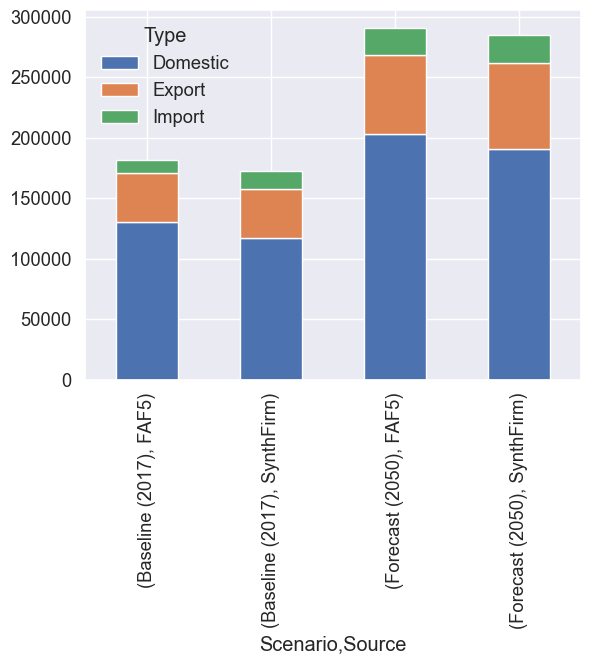

In [45]:
# add composition by source
# Source

# production
prod_comparison_by_source = \
pd.concat([faf_prod_by_source, modeled_prod_by_source])
# prod_comparison_by_source.head(5)
prod_comparison_by_source = \
pd.pivot_table(prod_comparison_by_source, 
               index = ['Scenario', 'Source'],
              columns = 'Type', values = 'Load', aggfunc = 'sum')
prod_comparison_by_source.plot.bar(stacked = True)

Baseline (2017)
Forecast (2050)


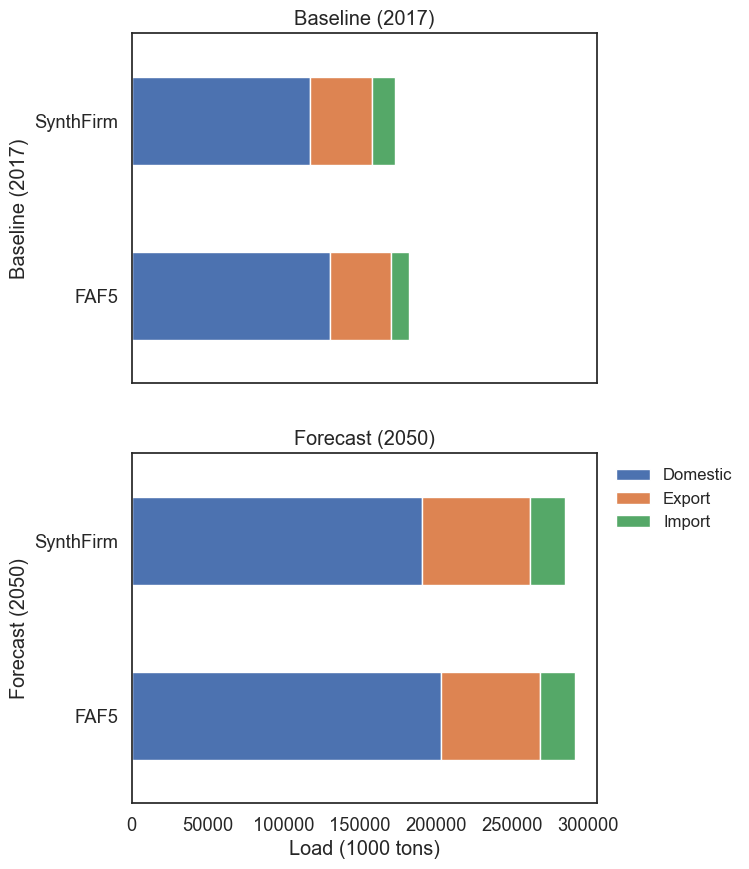

In [92]:
plt.style.use('seaborn-v0_8-white')
sns.set(font_scale=1.2)
sns.set_style("white")

def plot_function(df, x, ax):
    print(x)
    ax = graph[x]
    # print(type(ax))

    # ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    df.xs(x).plot(kind='barh', stacked='True', ax=ax, legend=False)
    ax.set_ylabel(x)
    ax.set_xlabel('Load (1000 tons)')
    ax.set_title(x)
    

n_subplots = len(prod_comparison_by_source.index.levels[0])
fig, axes = plt.subplots(nrows=n_subplots, ncols=1, sharex=True, figsize=(6, 10))  # width, height

graph = dict(zip(prod_comparison_by_source.index.levels[0], axes))
plots = list(map(lambda x: plot_function(prod_comparison_by_source, x, graph[x]), graph))
ax.tick_params(axis='both', which='both', length=0)
fig.subplots_adjust(wspace=0)

plt.legend(bbox_to_anchor = (1.01, 1), fontsize = 12)

plt.savefig(os.path.join(plot_dir, 'production_forecast_by_source.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

Baseline (2017)
Forecast (2050)


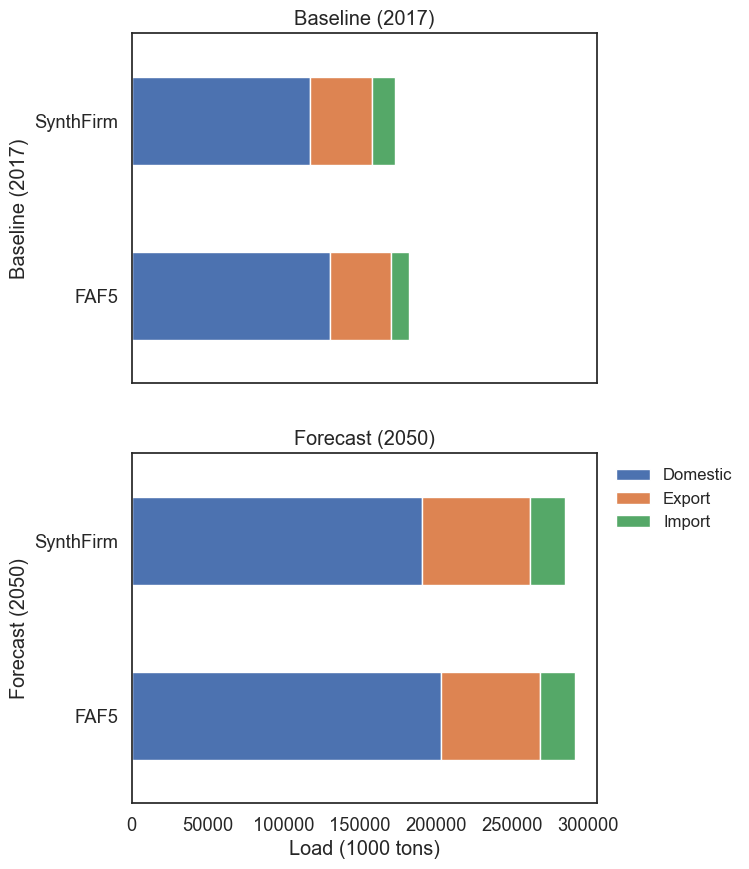

In [94]:
# production
cons_comparison_by_source = \
pd.concat([faf_cons_by_source, modeled_cons_by_source])
# prod_comparison_by_source.head(5)
cons_comparison_by_source = \
pd.pivot_table(cons_comparison_by_source, 
               index = ['Scenario', 'Source'],
              columns = 'Type', values = 'Load', aggfunc = 'sum')
n_subplots = len(cons_comparison_by_source.index.levels[0])
fig, axes = plt.subplots(nrows=n_subplots, ncols=1, sharex=True, figsize=(6, 10))  # width, height

graph = dict(zip(cons_comparison_by_source.index.levels[0], axes))
plots = list(map(lambda x: plot_function(prod_comparison_by_source, x, graph[x]), graph))
ax.tick_params(axis='both', which='both', length=0)
fig.subplots_adjust(wspace=0)

plt.legend(bbox_to_anchor = (1.01, 1), fontsize = 12)

plt.savefig(os.path.join(plot_dir, 'consumption_forecast_by_source.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

In [105]:
# plot emp difference
synthfirm_emp_comparison_cbg.loc[:, 'Delta emp (2050-2018)'] =\
synthfirm_emp_comparison_cbg.loc[:, 'SynthFirm_emp_2050'] - \
synthfirm_emp_comparison_cbg.loc[:, 'SynthFirm_emp_2018']
emp_change_comparison = \
region_map.merge(synthfirm_emp_comparison_cbg,
                 on = ['MESOZONE'], how = 'inner')
emp_change_comparison.head(5)

GEOID  FAFID      MESOZONE  CBPZONE  \
0  530330293053    531  530330293053    53033   
1  530330205002    531  530330205002    53033   
2  530530620003    531  530530620003    53053   
3  530530613002    531  530530613002    53053   
4  530330105001    531  530330105001    53033   

                                            geometry      area  \
0  MULTIPOLYGON (((-122.21292 47.42784, -122.2129...  0.891907   
1  MULTIPOLYGON (((-122.31347 47.75749, -122.3085...  0.435127   
2  MULTIPOLYGON (((-122.42101 47.23054, -122.4164...  0.291051   
3  MULTIPOLYGON (((-122.46102 47.25418, -122.4538...  0.254453   
4  MULTIPOLYGON (((-122.38146 47.56287, -122.3792...  0.266125   

   SynthFirm_emp_2018  SynthFirm_emp_2050  Delta emp (2050-2018)  
0          177.106681          212.656683              35.550002  
1           94.881945           63.942199             -30.939746  
2            7.892171           14.615369               6.723197  
3           56.634507           91.973106              35.338599  
4         1861.860081         2926.142533            1064.282452

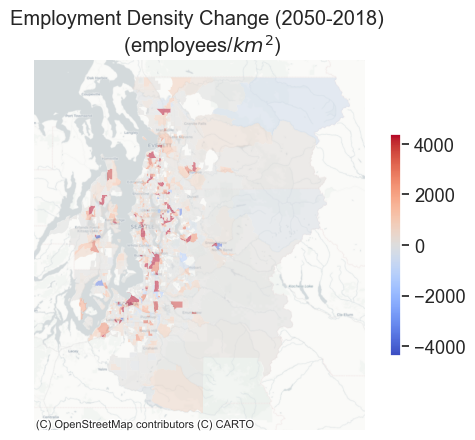

In [109]:
# plot emp change
upper_bound = emp_change_comparison['Delta emp (2050-2018)'].quantile(0.975)
lower_bound = emp_change_comparison['Delta emp (2050-2018)'].quantile(0.025)
upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
# upper_bound = upper_bound_lookup_mode[mode]
lower_bound = -upper_bound

file_prefix = 'emp_change'
filename = os.path.join(plot_dir, file_prefix + '_by_zone.png')

title = f'Employment Density Change (2050-2018) \n (employees/$km^{2}$)'
delta_attr = 'Delta emp (2050-2018)'
plot_region_map(emp_change_comparison, delta_attr, title,
            filename, logscale = False, 
            vmin=lower_bound, vmax=upper_bound, legend_scale = 0.6, alpha=0.5, cmap='coolwarm')